## 定义常量

In [129]:
# defines

# 初始目录
DIR_TRAIN = './data/train'
DIR_TRAIN_TMP = './data/train_tmp'
DIR_VALIDATION = './data/valid'
DIR_TEST = './data/test'
DIR_REVIEW = './data/review'
DIR_IRQ_REVIEW = './data/irq_review'

# 处理目录
CLASSES_CSV = './data/ImageNetClasses.csv'
DIR_TRAIN_NEW = './data/train_new'
DIR_TRAIN_NEW_DOG = './data/train_new/dogs'
DIR_TRAIN_NEW_CAT = './data/train_new/cats'

IMG_SIZE = (299,299)
IMG_SHAPE = (299, 299, 3)

## 常用库

In [141]:
import os
import cv2
import numpy as np
import random
import h5py
import shutil

import pandas as pd           
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from tqdm import tqdm

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint

%matplotlib inline   

## 数据探索

Number of Dat Images: 12500
Number of Dog Images: 12500


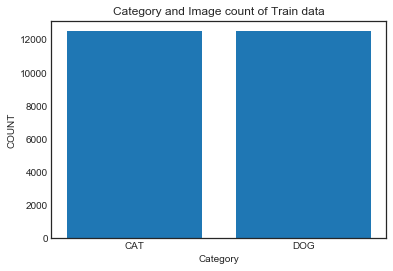

In [17]:
# 训练集
files = os.listdir(DIR_TRAIN)
cats = [img for img in filter(lambda x:x[:3] == 'cat', files)]
dogs = [img for img in filter(lambda x:x[:3] == 'dog', files)]
image_files = np.concatenate((cats,dogs))

print("Number of Dat Images: {0}".format(len(cats)))
print("Number of Dog Images: {0}".format(len(dogs)))

x =np.array([len(cats),len(dogs)])
plt.bar(['CAT','DOG'],[x[0],x[1]])
plt.xlabel('Category')
plt.ylabel('COUNT')
plt.title('Category and Image count of Train data')
plt.show()

In [1]:
# 随机打印集合中的图片 4 x 4
def random_print_16_images(files, path, size):
    plt.style.use('seaborn-white')
    random.seed(50)

    fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))

    #随机获取图片 4x4
    for i in range(4):
        for j in range(4):
            index = random.randint(0,size)
            img = cv2.imread(os.path.join(path,files[index]))
            ax[i,j].set_title('{0}'.format(files[index]))
            ax[i,j].imshow(img)

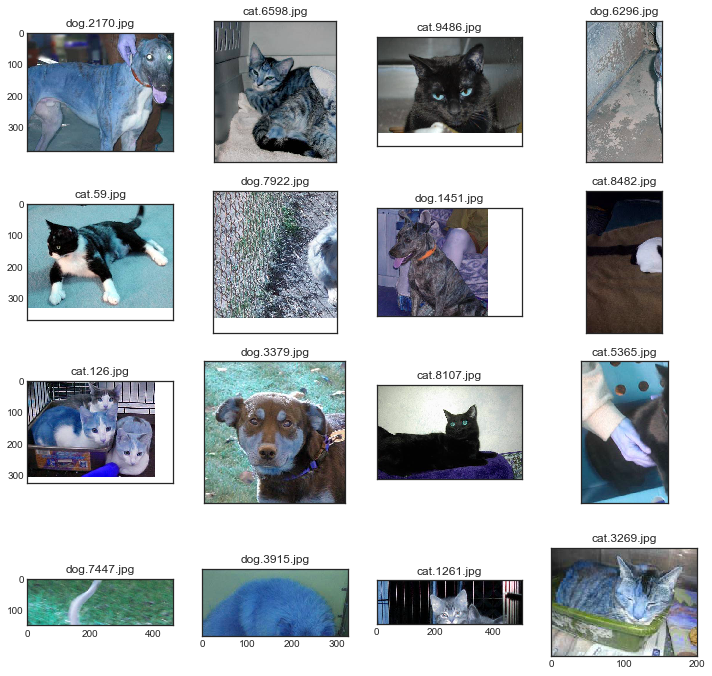

In [5]:
random_print_16_images(total, DIR_TRAIN, 25000)

In [18]:
# 探索图片宽高大小
def image_size_statictics(path, files, staticsName):
    heights, widths = [], []
    for image_file in tqdm(files):
        img = load_img(os.path.join(path,image_file))
        x = img_to_array(img)
        heights.append(x.shape[0])
        widths.append(x.shape[1])
        
    x = np.array(widths)
    y = np.array(heights)
    
    plt.scatter(x, y, c='r', alpha=0.1, marker = 'o')
    plt.title('Statistics of {0} image size'.format(staticsName))
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

100%|██████████| 12500/12500 [00:38<00:00, 326.69it/s]


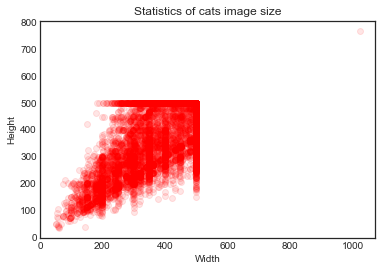

In [7]:
# 训练集 -cats- 图片size
image_size_statictics(DIR_TRAIN, cats, 'cats')

100%|██████████| 12500/12500 [00:38<00:00, 321.79it/s]


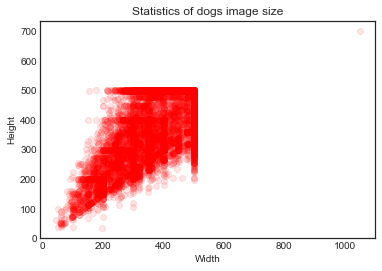

In [8]:
# 训练集 -dogs- 图片size
image_size_statictics(DIR_TRAIN, dogs, 'dogs')

100%|██████████| 12500/12500 [00:38<00:00, 328.28it/s]


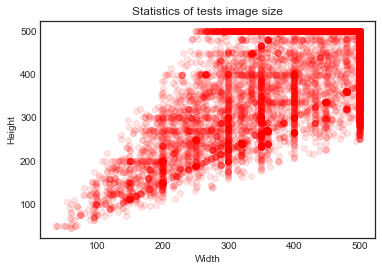

In [9]:
# 测试集 - 图片 size
test_files = os.listdir(DIR_TEST)
image_size_statictics(DIR_TEST, test_files, 'tests')

## 数据预处理

### IQR分析

In [10]:
# 通过对图片进行色彩–像素比进行IQR分析，剔除分辨率低、无关的图片。
from PIL import Image
from collections import Counter

plt.style.use('seaborn-white')

ratio_list = []

for image_file in tqdm(image_files):
    im = Image.open(os.path.join(DIR_TRAIN,image_file))
    x = im.histogram(mask=None)
    count = Counter(x)    
    ratio_list.append(float(len(count))/len(x))

100%|██████████| 25000/25000 [01:02<00:00, 400.84it/s]


In [11]:
q99, q01 = np.percentile(ratio_list, [99, 1])

print(q99, q01)

0.8020833333333334 0.20052083333333334


In [12]:
excpetion_pictures = []

for image_file in tqdm(image_files):
    image_path = os.path.join(DIR_TRAIN,image_file)
    im = Image.open(image_path)
    x = im.histogram(mask=None)
    count = Counter(x)
    if float(len(count))/len(x) < q01:
        excpetion_pictures.append(image_file)

100%|██████████| 25000/25000 [01:01<00:00, 407.59it/s]


In [21]:
print(len(excpetion_pictures))

249


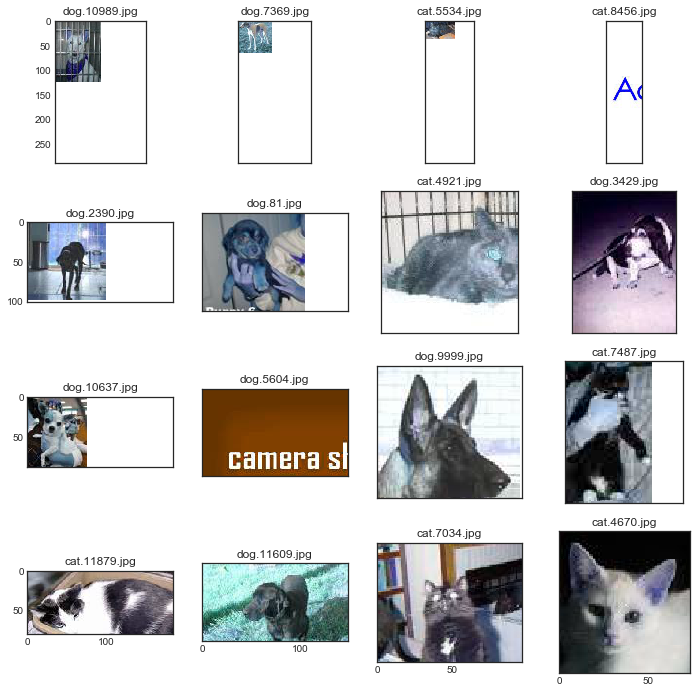

In [22]:
# 随机打印检测出的异常图片
random_print_16_images(excpetion_pictures, DIR_TRAIN, len(excpetion_pictures))

In [24]:
# 把IRQ分析出的异常图片放到 DIR_IRQ_REVIEW，然后再人工检查一遍
import shutil

if not os.path.exists(DIR_IRQ_REVIEW):
    os.mkdir(DIR_IRQ_REVIEW)
    
for file in excpetion_pictures:
    shutil.copy(os.path.join(DIR_TRAIN, file), DIR_IRQ_REVIEW)

### 使用 InceptionV3识别

In [38]:
import csv

# 获取ImageNet图片分类
# 参考: https://blog.csdn.net/zhangjunbob/article/details/53258524
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsid_to_human-txt
def get_imageNet_class(file_path):
    category_class = []
    with open(file_path, newline='') as f:
        reader = csv.reader(f, delimiter=',')
        for line in reader:
            if line[1] == '狗' or line[1] == '猫':
                category_class.append(line[0])
    return category_class

dog_cat_classes = get_imageNet_class(CLASSES_CSV)

In [68]:
print(len(dog_cat_classes))
print(dog_cat_classes)

125
['n02085620', 'n02085782', 'n02085936', 'n02086079', 'n02086240', 'n02086646', 'n02086910', 'n02087046', 'n02087394', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02088632', 'n02089078', 'n02089867', 'n02089973', 'n02090379', 'n02090622', 'n02090721', 'n02091032', 'n02091134', 'n02091244', 'n02091467', 'n02091635', 'n02091831', 'n02092002', 'n02092339', 'n02093256', 'n02093428', 'n02093647', 'n02093754', 'n02093859', 'n02093991', 'n02094114', 'n02094258', 'n02094433', 'n02095314', 'n02095570', 'n02095889', 'n02096051', 'n02096177', 'n02096294', 'n02096437', 'n02096585', 'n02097047', 'n02097130', 'n02097209', 'n02097298', 'n02097474', 'n02097658', 'n02098105', 'n02098286', 'n02098413', 'n02099267', 'n02099429', 'n02099601', 'n02099712', 'n02099849', 'n02100236', 'n02100583', 'n02100735', 'n02100877', 'n02101006', 'n02101388', 'n02101556', 'n02102040', 'n02102177', 'n02102318', 'n02102480', 'n02102973', 'n02104029', 'n02104365', 'n02105056', 'n02105162', 'n02105251', 'n02105

In [42]:
# InceptionV3 模型
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

# 定义InceptionV3模型
InceptionV3_model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [127]:
# 把检测为非猫和狗的图片复制到'./data/review'目录，然后再人工检测一遍
# 把识别正确的图片复制到'./data/train_new'目录，为后面迁移模型训练做准备。
if not os.path.exists(DIR_REVIEW):
    os.mkdir(DIR_REVIEW)

if not os.path.exists(DIR_TRAIN_NEW):
    os.mkdir(DIR_TRAIN_NEW)

In [136]:
def invalid_cat_dog_detector(file_dir, model, img_size, top=10):
    invalid_files = []
    
    files_tmp = os.listdir(file_dir)
    for file in tqdm(files_tmp[:]):
        if not (file.endswith('JPG') or file.endswith('jpg')):
            continue
            
        file_full_path = os.path.join(file_dir, file)
        img = image.load_img(file_full_path, target_size=img_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        predictions = decode_predictions(preds, top=top)[0]
        
        isValid = False
        for p in predictions:
            if p[0] in dog_cat_classes:
                isValid = True
                break
        
        if isValid:
            if file[:3] == 'cat':
                shutil.copy(file_full_path, DIR_TRAIN_NEW_CAT)
            if file[:3] == 'dog':
                shutil.copy(file_full_path, DIR_TRAIN_NEW_DOG)
        else:
            invalid_files.append(file)
            shutil.copy(file_full_path, DIR_REVIEW)
            
    return invalid_files   

In [137]:
invalid_files = invalid_cat_dog_detector(DIR_TRAIN, InceptionV3_model, IMG_SIZE, 30)





  0%|          | 0/25000 [00:00<?, ?it/s]



  0%|          | 1/25000 [00:00<1:42:12,  4.08it/s]



  0%|          | 2/25000 [00:00<1:45:25,  3.95it/s]



  0%|          | 3/25000 [00:00<1:44:31,  3.99it/s]



  0%|          | 4/25000 [00:01<1:43:38,  4.02it/s]



  0%|          | 5/25000 [00:01<1:44:15,  4.00it/s]



  0%|          | 6/25000 [00:01<1:44:33,  3.98it/s]



  0%|          | 7/25000 [00:01<1:46:48,  3.90it/s]



  0%|          | 8/25000 [00:02<1:44:54,  3.97it/s]



  0%|          | 9/25000 [00:02<1:43:14,  4.03it/s]



  0%|          | 10/25000 [00:02<1:40:40,  4.14it/s]



  0%|          | 11/25000 [00:02<1:39:44,  4.18it/s]



  0%|          | 12/25000 [00:02<1:40:32,  4.14it/s]



  0%|          | 13/25000 [00:03<1:46:09,  3.92it/s]



  0%|          | 14/25000 [00:03<1:51:07,  3.75it/s]



  0%|          | 15/25000 [00:03<2:05:05,  3.33it/s]



  0%|          | 16/25000 [00:04<2:03:11,  3.38it/s]



  0%|          | 17/25000 [00:04<2:02:26,  3.40it/s]



  0%|   

  1%|          | 238/25000 [01:00<1:47:33,  3.84it/s]



  1%|          | 239/25000 [01:00<1:46:48,  3.86it/s]



  1%|          | 240/25000 [01:00<1:46:36,  3.87it/s]



  1%|          | 241/25000 [01:00<1:43:42,  3.98it/s]



  1%|          | 242/25000 [01:01<1:43:57,  3.97it/s]



  1%|          | 243/25000 [01:01<1:43:35,  3.98it/s]



  1%|          | 244/25000 [01:01<1:45:51,  3.90it/s]



  1%|          | 245/25000 [01:01<1:48:51,  3.79it/s]



  1%|          | 246/25000 [01:02<1:47:07,  3.85it/s]



  1%|          | 247/25000 [01:02<1:41:18,  4.07it/s]



  1%|          | 248/25000 [01:02<1:41:33,  4.06it/s]



  1%|          | 249/25000 [01:02<1:41:54,  4.05it/s]



  1%|          | 250/25000 [01:03<1:42:00,  4.04it/s]



  1%|          | 251/25000 [01:03<1:40:03,  4.12it/s]



  1%|          | 252/25000 [01:03<1:40:22,  4.11it/s]



  1%|          | 253/25000 [01:03<1:40:16,  4.11it/s]



  1%|          | 254/25000 [01:04<1:39:38,  4.14it/s]



  1%|          | 255/25000 [01:

  2%|▏         | 474/25000 [02:01<2:08:03,  3.19it/s]



  2%|▏         | 475/25000 [02:01<2:11:30,  3.11it/s]



  2%|▏         | 476/25000 [02:01<2:04:57,  3.27it/s]



  2%|▏         | 477/25000 [02:02<1:56:21,  3.51it/s]



  2%|▏         | 478/25000 [02:02<1:50:08,  3.71it/s]



  2%|▏         | 479/25000 [02:02<1:45:50,  3.86it/s]



  2%|▏         | 480/25000 [02:02<1:43:24,  3.95it/s]



  2%|▏         | 481/25000 [02:03<1:41:14,  4.04it/s]



  2%|▏         | 482/25000 [02:03<1:40:38,  4.06it/s]



  2%|▏         | 483/25000 [02:03<1:39:12,  4.12it/s]



  2%|▏         | 484/25000 [02:03<1:38:22,  4.15it/s]



  2%|▏         | 485/25000 [02:03<1:38:03,  4.17it/s]



  2%|▏         | 486/25000 [02:04<1:37:20,  4.20it/s]



  2%|▏         | 487/25000 [02:04<1:37:33,  4.19it/s]



  2%|▏         | 488/25000 [02:04<1:37:49,  4.18it/s]



  2%|▏         | 489/25000 [02:04<1:36:07,  4.25it/s]



  2%|▏         | 490/25000 [02:05<1:36:24,  4.24it/s]



  2%|▏         | 491/25000 [02:

  3%|▎         | 710/25000 [02:58<1:35:37,  4.23it/s]



  3%|▎         | 711/25000 [02:58<1:34:52,  4.27it/s]



  3%|▎         | 712/25000 [02:58<1:35:11,  4.25it/s]



  3%|▎         | 713/25000 [02:59<1:34:40,  4.28it/s]



  3%|▎         | 714/25000 [02:59<1:33:53,  4.31it/s]



  3%|▎         | 715/25000 [02:59<1:34:44,  4.27it/s]



  3%|▎         | 716/25000 [02:59<1:34:32,  4.28it/s]



  3%|▎         | 717/25000 [03:00<1:34:33,  4.28it/s]



  3%|▎         | 718/25000 [03:00<1:35:11,  4.25it/s]



  3%|▎         | 719/25000 [03:00<1:33:13,  4.34it/s]



  3%|▎         | 720/25000 [03:00<1:32:24,  4.38it/s]



  3%|▎         | 721/25000 [03:00<1:32:31,  4.37it/s]



  3%|▎         | 722/25000 [03:01<1:32:42,  4.36it/s]



  3%|▎         | 723/25000 [03:01<1:33:29,  4.33it/s]



  3%|▎         | 724/25000 [03:01<1:34:18,  4.29it/s]



  3%|▎         | 725/25000 [03:01<1:34:37,  4.28it/s]



  3%|▎         | 726/25000 [03:02<1:33:22,  4.33it/s]



  3%|▎         | 727/25000 [03:

  4%|▍         | 946/25000 [03:55<1:34:24,  4.25it/s]



  4%|▍         | 947/25000 [03:55<1:34:10,  4.26it/s]



  4%|▍         | 948/25000 [03:55<1:36:03,  4.17it/s]



  4%|▍         | 949/25000 [03:56<1:36:29,  4.15it/s]



  4%|▍         | 950/25000 [03:56<1:39:19,  4.04it/s]



  4%|▍         | 951/25000 [03:56<1:39:49,  4.02it/s]



  4%|▍         | 952/25000 [03:56<1:36:28,  4.15it/s]



  4%|▍         | 953/25000 [03:57<1:34:51,  4.23it/s]



  4%|▍         | 954/25000 [03:57<1:34:44,  4.23it/s]



  4%|▍         | 955/25000 [03:57<1:34:04,  4.26it/s]



  4%|▍         | 956/25000 [03:57<1:34:28,  4.24it/s]



  4%|▍         | 957/25000 [03:57<1:32:12,  4.35it/s]



  4%|▍         | 958/25000 [03:58<1:32:39,  4.32it/s]



  4%|▍         | 959/25000 [03:58<1:33:26,  4.29it/s]



  4%|▍         | 960/25000 [03:58<1:33:04,  4.30it/s]



  4%|▍         | 961/25000 [03:58<1:36:05,  4.17it/s]



  4%|▍         | 962/25000 [03:59<1:44:25,  3.84it/s]



  4%|▍         | 963/25000 [03:

  5%|▍         | 1180/25000 [04:51<1:34:42,  4.19it/s]



  5%|▍         | 1181/25000 [04:52<1:34:16,  4.21it/s]



  5%|▍         | 1182/25000 [04:52<1:33:05,  4.26it/s]



  5%|▍         | 1183/25000 [04:52<1:33:56,  4.23it/s]



  5%|▍         | 1184/25000 [04:52<1:32:41,  4.28it/s]



  5%|▍         | 1185/25000 [04:52<1:33:57,  4.22it/s]



  5%|▍         | 1186/25000 [04:53<1:41:54,  3.89it/s]



  5%|▍         | 1187/25000 [04:53<1:55:35,  3.43it/s]



  5%|▍         | 1188/25000 [04:53<1:49:54,  3.61it/s]



  5%|▍         | 1189/25000 [04:54<1:45:13,  3.77it/s]



  5%|▍         | 1190/25000 [04:54<1:42:10,  3.88it/s]



  5%|▍         | 1191/25000 [04:54<1:40:26,  3.95it/s]



  5%|▍         | 1192/25000 [04:54<1:36:25,  4.12it/s]



  5%|▍         | 1193/25000 [04:55<1:34:41,  4.19it/s]



  5%|▍         | 1194/25000 [04:55<1:33:56,  4.22it/s]



  5%|▍         | 1195/25000 [04:55<1:34:05,  4.22it/s]



  5%|▍         | 1196/25000 [04:55<1:32:30,  4.29it/s]



  5%|▍        

  6%|▌         | 1414/25000 [05:50<1:32:53,  4.23it/s]



  6%|▌         | 1415/25000 [05:51<1:34:28,  4.16it/s]



  6%|▌         | 1416/25000 [05:51<1:38:16,  4.00it/s]



  6%|▌         | 1417/25000 [05:51<1:37:29,  4.03it/s]



  6%|▌         | 1418/25000 [05:51<1:37:40,  4.02it/s]



  6%|▌         | 1419/25000 [05:52<1:40:31,  3.91it/s]



  6%|▌         | 1420/25000 [05:52<1:37:35,  4.03it/s]



  6%|▌         | 1421/25000 [05:52<1:38:04,  4.01it/s]



  6%|▌         | 1422/25000 [05:52<1:39:16,  3.96it/s]



  6%|▌         | 1423/25000 [05:53<1:41:45,  3.86it/s]



  6%|▌         | 1424/25000 [05:53<1:38:56,  3.97it/s]



  6%|▌         | 1425/25000 [05:53<1:37:11,  4.04it/s]



  6%|▌         | 1426/25000 [05:53<1:37:50,  4.02it/s]



  6%|▌         | 1427/25000 [05:54<1:41:50,  3.86it/s]



  6%|▌         | 1428/25000 [05:54<1:39:36,  3.94it/s]



  6%|▌         | 1429/25000 [05:54<1:37:48,  4.02it/s]



  6%|▌         | 1430/25000 [05:54<1:35:58,  4.09it/s]



  6%|▌        

  7%|▋         | 1648/25000 [06:48<1:52:58,  3.44it/s]



  7%|▋         | 1649/25000 [06:49<1:48:29,  3.59it/s]



  7%|▋         | 1650/25000 [06:49<1:44:49,  3.71it/s]



  7%|▋         | 1651/25000 [06:49<1:41:52,  3.82it/s]



  7%|▋         | 1652/25000 [06:49<1:38:18,  3.96it/s]



  7%|▋         | 1653/25000 [06:50<1:35:34,  4.07it/s]



  7%|▋         | 1654/25000 [06:50<1:34:18,  4.13it/s]



  7%|▋         | 1655/25000 [06:50<1:32:57,  4.19it/s]



  7%|▋         | 1656/25000 [06:50<1:33:16,  4.17it/s]



  7%|▋         | 1657/25000 [06:51<1:33:53,  4.14it/s]



  7%|▋         | 1658/25000 [06:51<1:31:56,  4.23it/s]



  7%|▋         | 1659/25000 [06:51<1:31:56,  4.23it/s]



  7%|▋         | 1660/25000 [06:51<1:29:02,  4.37it/s]



  7%|▋         | 1661/25000 [06:51<1:28:55,  4.37it/s]



  7%|▋         | 1662/25000 [06:52<1:27:55,  4.42it/s]



  7%|▋         | 1663/25000 [06:52<1:31:07,  4.27it/s]



  7%|▋         | 1664/25000 [06:52<1:31:57,  4.23it/s]



  7%|▋        

  8%|▊         | 1882/25000 [07:45<1:34:01,  4.10it/s]



  8%|▊         | 1883/25000 [07:45<1:34:39,  4.07it/s]



  8%|▊         | 1884/25000 [07:46<1:33:21,  4.13it/s]



  8%|▊         | 1885/25000 [07:46<1:32:45,  4.15it/s]



  8%|▊         | 1886/25000 [07:46<1:31:47,  4.20it/s]



  8%|▊         | 1887/25000 [07:46<1:29:49,  4.29it/s]



  8%|▊         | 1888/25000 [07:47<1:29:25,  4.31it/s]



  8%|▊         | 1889/25000 [07:47<1:30:10,  4.27it/s]



  8%|▊         | 1890/25000 [07:47<1:31:28,  4.21it/s]



  8%|▊         | 1891/25000 [07:47<1:31:49,  4.19it/s]



  8%|▊         | 1892/25000 [07:47<1:33:37,  4.11it/s]



  8%|▊         | 1893/25000 [07:48<1:34:07,  4.09it/s]



  8%|▊         | 1894/25000 [07:48<1:35:45,  4.02it/s]



  8%|▊         | 1895/25000 [07:48<1:35:20,  4.04it/s]



  8%|▊         | 1896/25000 [07:48<1:35:28,  4.03it/s]



  8%|▊         | 1897/25000 [07:49<1:33:58,  4.10it/s]



  8%|▊         | 1898/25000 [07:49<1:33:34,  4.11it/s]



  8%|▊        

  8%|▊         | 2116/25000 [08:42<1:32:39,  4.12it/s]



  8%|▊         | 2117/25000 [08:42<1:31:20,  4.18it/s]



  8%|▊         | 2118/25000 [08:43<1:29:50,  4.25it/s]



  8%|▊         | 2119/25000 [08:43<1:30:02,  4.24it/s]



  8%|▊         | 2120/25000 [08:43<1:31:25,  4.17it/s]



  8%|▊         | 2121/25000 [08:43<1:32:39,  4.12it/s]



  8%|▊         | 2122/25000 [08:44<1:32:55,  4.10it/s]



  8%|▊         | 2123/25000 [08:44<1:32:48,  4.11it/s]



  8%|▊         | 2124/25000 [08:44<1:31:32,  4.16it/s]



  8%|▊         | 2125/25000 [08:44<1:31:19,  4.17it/s]



  9%|▊         | 2126/25000 [08:44<1:30:47,  4.20it/s]



  9%|▊         | 2127/25000 [08:45<1:29:44,  4.25it/s]



  9%|▊         | 2128/25000 [08:45<1:29:09,  4.28it/s]



  9%|▊         | 2129/25000 [08:45<1:28:55,  4.29it/s]



  9%|▊         | 2130/25000 [08:45<1:28:50,  4.29it/s]



  9%|▊         | 2131/25000 [08:46<1:34:29,  4.03it/s]



  9%|▊         | 2132/25000 [08:46<1:45:12,  3.62it/s]



  9%|▊        

  9%|▉         | 2350/25000 [09:39<1:32:37,  4.08it/s]



  9%|▉         | 2351/25000 [09:39<1:38:11,  3.84it/s]



  9%|▉         | 2352/25000 [09:39<1:53:33,  3.32it/s]



  9%|▉         | 2353/25000 [09:40<1:48:07,  3.49it/s]



  9%|▉         | 2354/25000 [09:40<1:43:22,  3.65it/s]



  9%|▉         | 2355/25000 [09:40<1:39:19,  3.80it/s]



  9%|▉         | 2356/25000 [09:40<1:36:03,  3.93it/s]



  9%|▉         | 2357/25000 [09:41<1:32:50,  4.06it/s]



  9%|▉         | 2358/25000 [09:41<1:32:15,  4.09it/s]



  9%|▉         | 2359/25000 [09:41<1:30:17,  4.18it/s]



  9%|▉         | 2360/25000 [09:41<1:28:20,  4.27it/s]



  9%|▉         | 2361/25000 [09:42<1:27:55,  4.29it/s]



  9%|▉         | 2362/25000 [09:42<1:27:49,  4.30it/s]



  9%|▉         | 2363/25000 [09:42<1:29:12,  4.23it/s]



  9%|▉         | 2364/25000 [09:42<1:28:29,  4.26it/s]



  9%|▉         | 2365/25000 [09:43<1:29:50,  4.20it/s]



  9%|▉         | 2366/25000 [09:43<1:29:52,  4.20it/s]



  9%|▉        

 10%|█         | 2584/25000 [10:36<1:29:34,  4.17it/s]



 10%|█         | 2585/25000 [10:36<1:31:06,  4.10it/s]



 10%|█         | 2586/25000 [10:37<1:30:53,  4.11it/s]



 10%|█         | 2587/25000 [10:37<1:30:22,  4.13it/s]



 10%|█         | 2588/25000 [10:37<1:30:21,  4.13it/s]



 10%|█         | 2589/25000 [10:37<1:28:51,  4.20it/s]



 10%|█         | 2590/25000 [10:37<1:28:04,  4.24it/s]



 10%|█         | 2591/25000 [10:38<1:28:33,  4.22it/s]



 10%|█         | 2592/25000 [10:38<1:28:25,  4.22it/s]



 10%|█         | 2593/25000 [10:38<1:29:20,  4.18it/s]



 10%|█         | 2594/25000 [10:38<1:29:09,  4.19it/s]



 10%|█         | 2595/25000 [10:39<1:30:38,  4.12it/s]



 10%|█         | 2596/25000 [10:39<1:31:13,  4.09it/s]



 10%|█         | 2597/25000 [10:39<1:31:47,  4.07it/s]



 10%|█         | 2598/25000 [10:39<1:31:27,  4.08it/s]



 10%|█         | 2599/25000 [10:40<1:30:53,  4.11it/s]



 10%|█         | 2600/25000 [10:40<1:29:21,  4.18it/s]



 10%|█        

 11%|█▏        | 2818/25000 [11:34<1:41:14,  3.65it/s]



 11%|█▏        | 2819/25000 [11:34<1:40:13,  3.69it/s]



 11%|█▏        | 2820/25000 [11:34<1:37:17,  3.80it/s]



 11%|█▏        | 2821/25000 [11:35<1:34:28,  3.91it/s]



 11%|█▏        | 2822/25000 [11:35<1:33:26,  3.96it/s]



 11%|█▏        | 2823/25000 [11:35<1:31:51,  4.02it/s]



 11%|█▏        | 2824/25000 [11:35<1:30:49,  4.07it/s]



 11%|█▏        | 2825/25000 [11:36<1:30:02,  4.10it/s]



 11%|█▏        | 2826/25000 [11:36<1:29:23,  4.13it/s]



 11%|█▏        | 2827/25000 [11:36<1:29:17,  4.14it/s]



 11%|█▏        | 2828/25000 [11:36<1:28:19,  4.18it/s]



 11%|█▏        | 2829/25000 [11:36<1:27:25,  4.23it/s]



 11%|█▏        | 2830/25000 [11:37<1:27:35,  4.22it/s]



 11%|█▏        | 2831/25000 [11:37<1:27:10,  4.24it/s]



 11%|█▏        | 2832/25000 [11:37<1:26:48,  4.26it/s]



 11%|█▏        | 2833/25000 [11:37<1:30:24,  4.09it/s]



 11%|█▏        | 2834/25000 [11:38<1:33:34,  3.95it/s]



 11%|█▏       

 12%|█▏        | 3052/25000 [12:31<1:27:56,  4.16it/s]



 12%|█▏        | 3053/25000 [12:31<1:27:28,  4.18it/s]



 12%|█▏        | 3054/25000 [12:31<1:27:30,  4.18it/s]



 12%|█▏        | 3055/25000 [12:32<1:27:40,  4.17it/s]



 12%|█▏        | 3056/25000 [12:32<1:31:26,  4.00it/s]



 12%|█▏        | 3057/25000 [12:32<1:42:10,  3.58it/s]



 12%|█▏        | 3058/25000 [12:33<1:39:43,  3.67it/s]



 12%|█▏        | 3059/25000 [12:33<1:34:21,  3.88it/s]



 12%|█▏        | 3060/25000 [12:33<1:32:18,  3.96it/s]



 12%|█▏        | 3061/25000 [12:33<1:30:17,  4.05it/s]



 12%|█▏        | 3062/25000 [12:33<1:29:11,  4.10it/s]



 12%|█▏        | 3063/25000 [12:34<1:28:38,  4.13it/s]



 12%|█▏        | 3064/25000 [12:34<1:27:31,  4.18it/s]



 12%|█▏        | 3065/25000 [12:34<1:25:59,  4.25it/s]



 12%|█▏        | 3066/25000 [12:34<1:23:18,  4.39it/s]



 12%|█▏        | 3067/25000 [12:35<1:23:22,  4.38it/s]



 12%|█▏        | 3068/25000 [12:35<1:24:16,  4.34it/s]



 12%|█▏       

 13%|█▎        | 3286/25000 [13:28<1:28:11,  4.10it/s]



 13%|█▎        | 3287/25000 [13:29<1:27:05,  4.16it/s]



 13%|█▎        | 3288/25000 [13:29<1:26:17,  4.19it/s]



 13%|█▎        | 3289/25000 [13:29<1:26:15,  4.20it/s]



 13%|█▎        | 3290/25000 [13:29<1:25:24,  4.24it/s]



 13%|█▎        | 3291/25000 [13:29<1:25:20,  4.24it/s]



 13%|█▎        | 3292/25000 [13:30<1:24:32,  4.28it/s]



 13%|█▎        | 3293/25000 [13:30<1:23:54,  4.31it/s]



 13%|█▎        | 3294/25000 [13:30<1:25:03,  4.25it/s]



 13%|█▎        | 3295/25000 [13:30<1:24:33,  4.28it/s]



 13%|█▎        | 3296/25000 [13:31<1:25:26,  4.23it/s]



 13%|█▎        | 3297/25000 [13:31<1:25:30,  4.23it/s]



 13%|█▎        | 3298/25000 [13:31<1:24:49,  4.26it/s]



 13%|█▎        | 3299/25000 [13:31<1:24:36,  4.27it/s]



 13%|█▎        | 3300/25000 [13:32<1:24:58,  4.26it/s]



 13%|█▎        | 3301/25000 [13:32<1:26:26,  4.18it/s]



 13%|█▎        | 3302/25000 [13:32<1:27:08,  4.15it/s]



 13%|█▎       

 14%|█▍        | 3520/25000 [14:26<1:27:06,  4.11it/s]



 14%|█▍        | 3521/25000 [14:26<1:27:38,  4.08it/s]



 14%|█▍        | 3522/25000 [14:26<1:27:04,  4.11it/s]



 14%|█▍        | 3523/25000 [14:26<1:27:17,  4.10it/s]



 14%|█▍        | 3524/25000 [14:27<1:27:29,  4.09it/s]



 14%|█▍        | 3525/25000 [14:27<1:25:27,  4.19it/s]



 14%|█▍        | 3526/25000 [14:27<1:25:33,  4.18it/s]



 14%|█▍        | 3527/25000 [14:27<1:25:05,  4.21it/s]



 14%|█▍        | 3528/25000 [14:28<1:27:20,  4.10it/s]



 14%|█▍        | 3529/25000 [14:28<1:34:27,  3.79it/s]



 14%|█▍        | 3530/25000 [14:28<1:42:07,  3.50it/s]



 14%|█▍        | 3531/25000 [14:29<1:37:47,  3.66it/s]



 14%|█▍        | 3532/25000 [14:29<1:34:15,  3.80it/s]



 14%|█▍        | 3533/25000 [14:29<1:31:53,  3.89it/s]



 14%|█▍        | 3534/25000 [14:29<1:29:17,  4.01it/s]



 14%|█▍        | 3535/25000 [14:30<1:27:57,  4.07it/s]



 14%|█▍        | 3536/25000 [14:30<1:27:37,  4.08it/s]



 14%|█▍       

 15%|█▌        | 3754/25000 [15:23<1:27:53,  4.03it/s]



 15%|█▌        | 3755/25000 [15:23<1:28:32,  4.00it/s]



 15%|█▌        | 3756/25000 [15:23<1:28:27,  4.00it/s]



 15%|█▌        | 3757/25000 [15:24<1:26:43,  4.08it/s]



 15%|█▌        | 3758/25000 [15:24<1:24:58,  4.17it/s]



 15%|█▌        | 3759/25000 [15:24<1:24:06,  4.21it/s]



 15%|█▌        | 3760/25000 [15:24<1:23:03,  4.26it/s]



 15%|█▌        | 3761/25000 [15:25<1:27:04,  4.07it/s]



 15%|█▌        | 3762/25000 [15:25<1:27:02,  4.07it/s]



 15%|█▌        | 3763/25000 [15:25<1:25:34,  4.14it/s]



 15%|█▌        | 3764/25000 [15:25<1:24:19,  4.20it/s]



 15%|█▌        | 3765/25000 [15:26<1:24:10,  4.20it/s]



 15%|█▌        | 3766/25000 [15:26<1:23:48,  4.22it/s]



 15%|█▌        | 3767/25000 [15:26<1:24:06,  4.21it/s]



 15%|█▌        | 3768/25000 [15:26<1:24:45,  4.18it/s]



 15%|█▌        | 3769/25000 [15:27<1:24:08,  4.21it/s]



 15%|█▌        | 3770/25000 [15:27<1:28:14,  4.01it/s]



 15%|█▌       

 16%|█▌        | 3988/25000 [16:20<1:23:23,  4.20it/s]



 16%|█▌        | 3989/25000 [16:20<1:24:51,  4.13it/s]



 16%|█▌        | 3990/25000 [16:21<1:24:30,  4.14it/s]



 16%|█▌        | 3991/25000 [16:21<1:23:37,  4.19it/s]



 16%|█▌        | 3992/25000 [16:21<1:24:22,  4.15it/s]



 16%|█▌        | 3993/25000 [16:21<1:24:00,  4.17it/s]



 16%|█▌        | 3994/25000 [16:22<1:23:57,  4.17it/s]



 16%|█▌        | 3995/25000 [16:22<1:23:10,  4.21it/s]



 16%|█▌        | 3996/25000 [16:22<1:23:51,  4.17it/s]



 16%|█▌        | 3997/25000 [16:22<1:23:44,  4.18it/s]



 16%|█▌        | 3998/25000 [16:23<1:23:30,  4.19it/s]



 16%|█▌        | 3999/25000 [16:23<1:24:44,  4.13it/s]



 16%|█▌        | 4000/25000 [16:23<1:23:48,  4.18it/s]



 16%|█▌        | 4001/25000 [16:23<1:25:24,  4.10it/s]



 16%|█▌        | 4002/25000 [16:24<1:25:03,  4.11it/s]



 16%|█▌        | 4003/25000 [16:24<1:25:04,  4.11it/s]



 16%|█▌        | 4004/25000 [16:24<1:24:25,  4.14it/s]



 16%|█▌       

 17%|█▋        | 4222/25000 [17:17<1:19:32,  4.35it/s]



 17%|█▋        | 4223/25000 [17:17<1:20:59,  4.28it/s]



 17%|█▋        | 4224/25000 [17:18<1:21:10,  4.27it/s]



 17%|█▋        | 4225/25000 [17:18<1:22:12,  4.21it/s]



 17%|█▋        | 4226/25000 [17:18<1:21:48,  4.23it/s]



 17%|█▋        | 4227/25000 [17:18<1:22:39,  4.19it/s]



 17%|█▋        | 4228/25000 [17:19<1:27:13,  3.97it/s]



 17%|█▋        | 4229/25000 [17:19<1:35:35,  3.62it/s]



 17%|█▋        | 4230/25000 [17:19<1:39:46,  3.47it/s]



 17%|█▋        | 4231/25000 [17:19<1:35:56,  3.61it/s]



 17%|█▋        | 4232/25000 [17:20<1:32:18,  3.75it/s]



 17%|█▋        | 4233/25000 [17:20<1:29:52,  3.85it/s]



 17%|█▋        | 4234/25000 [17:20<1:26:13,  4.01it/s]



 17%|█▋        | 4235/25000 [17:20<1:25:05,  4.07it/s]



 17%|█▋        | 4236/25000 [17:21<1:25:16,  4.06it/s]



 17%|█▋        | 4237/25000 [17:21<1:24:47,  4.08it/s]



 17%|█▋        | 4238/25000 [17:21<1:24:39,  4.09it/s]



 17%|█▋       

 18%|█▊        | 4456/25000 [18:15<1:26:57,  3.94it/s]



 18%|█▊        | 4457/25000 [18:15<1:30:22,  3.79it/s]



 18%|█▊        | 4458/25000 [18:15<1:30:40,  3.78it/s]



 18%|█▊        | 4459/25000 [18:15<1:29:54,  3.81it/s]



 18%|█▊        | 4460/25000 [18:16<1:27:58,  3.89it/s]



 18%|█▊        | 4461/25000 [18:16<1:26:45,  3.95it/s]



 18%|█▊        | 4462/25000 [18:16<1:26:48,  3.94it/s]



 18%|█▊        | 4463/25000 [18:16<1:24:40,  4.04it/s]



 18%|█▊        | 4464/25000 [18:17<1:23:55,  4.08it/s]



 18%|█▊        | 4465/25000 [18:17<1:22:45,  4.14it/s]



 18%|█▊        | 4466/25000 [18:17<1:21:51,  4.18it/s]



 18%|█▊        | 4467/25000 [18:17<1:20:59,  4.23it/s]



 18%|█▊        | 4468/25000 [18:18<1:20:34,  4.25it/s]



 18%|█▊        | 4469/25000 [18:18<1:20:15,  4.26it/s]



 18%|█▊        | 4470/25000 [18:18<1:21:28,  4.20it/s]



 18%|█▊        | 4471/25000 [18:18<1:21:44,  4.19it/s]



 18%|█▊        | 4472/25000 [18:19<1:21:10,  4.22it/s]



 18%|█▊       

 19%|█▉        | 4690/25000 [19:12<1:21:31,  4.15it/s]



 19%|█▉        | 4691/25000 [19:12<1:23:13,  4.07it/s]



 19%|█▉        | 4692/25000 [19:12<1:21:30,  4.15it/s]



 19%|█▉        | 4693/25000 [19:12<1:20:39,  4.20it/s]



 19%|█▉        | 4694/25000 [19:13<1:19:58,  4.23it/s]



 19%|█▉        | 4695/25000 [19:13<1:20:41,  4.19it/s]



 19%|█▉        | 4696/25000 [19:13<1:19:41,  4.25it/s]



 19%|█▉        | 4697/25000 [19:13<1:20:31,  4.20it/s]



 19%|█▉        | 4698/25000 [19:14<1:19:37,  4.25it/s]



 19%|█▉        | 4699/25000 [19:14<1:20:05,  4.22it/s]



 19%|█▉        | 4700/25000 [19:14<1:22:39,  4.09it/s]



 19%|█▉        | 4701/25000 [19:14<1:23:57,  4.03it/s]



 19%|█▉        | 4702/25000 [19:15<1:23:57,  4.03it/s]



 19%|█▉        | 4703/25000 [19:15<1:24:01,  4.03it/s]



 19%|█▉        | 4704/25000 [19:15<1:23:23,  4.06it/s]



 19%|█▉        | 4705/25000 [19:15<1:22:55,  4.08it/s]



 19%|█▉        | 4706/25000 [19:16<1:21:13,  4.16it/s]



 19%|█▉       

 20%|█▉        | 4924/25000 [20:07<1:21:17,  4.12it/s]



 20%|█▉        | 4925/25000 [20:07<1:19:38,  4.20it/s]



 20%|█▉        | 4926/25000 [20:08<1:19:29,  4.21it/s]



 20%|█▉        | 4927/25000 [20:08<1:18:00,  4.29it/s]



 20%|█▉        | 4928/25000 [20:08<1:16:58,  4.35it/s]



 20%|█▉        | 4929/25000 [20:08<1:16:41,  4.36it/s]



 20%|█▉        | 4930/25000 [20:09<1:17:54,  4.29it/s]



 20%|█▉        | 4931/25000 [20:09<1:18:30,  4.26it/s]



 20%|█▉        | 4932/25000 [20:09<1:18:59,  4.23it/s]



 20%|█▉        | 4933/25000 [20:09<1:18:34,  4.26it/s]



 20%|█▉        | 4934/25000 [20:09<1:18:12,  4.28it/s]



 20%|█▉        | 4935/25000 [20:10<1:18:30,  4.26it/s]



 20%|█▉        | 4936/25000 [20:10<1:21:48,  4.09it/s]



 20%|█▉        | 4937/25000 [20:10<1:25:14,  3.92it/s]



 20%|█▉        | 4938/25000 [20:11<1:38:09,  3.41it/s]



 20%|█▉        | 4939/25000 [20:11<1:33:31,  3.57it/s]



 20%|█▉        | 4940/25000 [20:11<1:28:54,  3.76it/s]



 20%|█▉       

 21%|██        | 5158/25000 [21:03<1:18:13,  4.23it/s]



 21%|██        | 5159/25000 [21:03<1:18:46,  4.20it/s]



 21%|██        | 5160/25000 [21:03<1:19:04,  4.18it/s]



 21%|██        | 5161/25000 [21:03<1:18:46,  4.20it/s]



 21%|██        | 5162/25000 [21:04<1:19:00,  4.18it/s]



 21%|██        | 5163/25000 [21:04<1:19:21,  4.17it/s]



 21%|██        | 5164/25000 [21:04<1:23:23,  3.96it/s]



 21%|██        | 5165/25000 [21:04<1:33:17,  3.54it/s]



 21%|██        | 5166/25000 [21:05<1:33:11,  3.55it/s]



 21%|██        | 5167/25000 [21:05<1:28:31,  3.73it/s]



 21%|██        | 5168/25000 [21:05<1:25:36,  3.86it/s]



 21%|██        | 5169/25000 [21:05<1:22:32,  4.00it/s]



 21%|██        | 5170/25000 [21:06<1:21:23,  4.06it/s]



 21%|██        | 5171/25000 [21:06<1:20:52,  4.09it/s]



 21%|██        | 5172/25000 [21:06<1:20:30,  4.10it/s]



 21%|██        | 5173/25000 [21:06<1:18:51,  4.19it/s]



 21%|██        | 5174/25000 [21:07<1:19:05,  4.18it/s]



 21%|██       

 22%|██▏       | 5392/25000 [21:58<1:34:21,  3.46it/s]



 22%|██▏       | 5393/25000 [21:58<1:30:16,  3.62it/s]



 22%|██▏       | 5394/25000 [21:59<1:26:38,  3.77it/s]



 22%|██▏       | 5395/25000 [21:59<1:24:34,  3.86it/s]



 22%|██▏       | 5396/25000 [21:59<1:21:49,  3.99it/s]



 22%|██▏       | 5397/25000 [21:59<1:21:51,  3.99it/s]



 22%|██▏       | 5398/25000 [22:00<1:21:08,  4.03it/s]



 22%|██▏       | 5399/25000 [22:00<1:18:55,  4.14it/s]



 22%|██▏       | 5400/25000 [22:00<1:18:29,  4.16it/s]



 22%|██▏       | 5401/25000 [22:00<1:17:08,  4.23it/s]



 22%|██▏       | 5402/25000 [22:00<1:16:01,  4.30it/s]



 22%|██▏       | 5403/25000 [22:01<1:15:46,  4.31it/s]



 22%|██▏       | 5404/25000 [22:01<1:15:04,  4.35it/s]



 22%|██▏       | 5405/25000 [22:01<1:15:44,  4.31it/s]



 22%|██▏       | 5406/25000 [22:01<1:15:55,  4.30it/s]



 22%|██▏       | 5407/25000 [22:02<1:16:24,  4.27it/s]



 22%|██▏       | 5408/25000 [22:02<1:16:43,  4.26it/s]



 22%|██▏      

 23%|██▎       | 5626/25000 [22:53<1:15:46,  4.26it/s]



 23%|██▎       | 5627/25000 [22:53<1:14:56,  4.31it/s]



 23%|██▎       | 5628/25000 [22:54<1:16:19,  4.23it/s]



 23%|██▎       | 5629/25000 [22:54<1:16:57,  4.19it/s]



 23%|██▎       | 5630/25000 [22:54<1:16:26,  4.22it/s]



 23%|██▎       | 5631/25000 [22:54<1:15:03,  4.30it/s]



 23%|██▎       | 5632/25000 [22:55<1:15:09,  4.29it/s]



 23%|██▎       | 5633/25000 [22:55<1:15:10,  4.29it/s]



 23%|██▎       | 5634/25000 [22:55<1:14:09,  4.35it/s]



 23%|██▎       | 5635/25000 [22:55<1:14:24,  4.34it/s]



 23%|██▎       | 5636/25000 [22:56<1:14:15,  4.35it/s]



 23%|██▎       | 5637/25000 [22:56<1:13:25,  4.40it/s]



 23%|██▎       | 5638/25000 [22:56<1:10:53,  4.55it/s]



 23%|██▎       | 5639/25000 [22:56<1:11:23,  4.52it/s]



 23%|██▎       | 5640/25000 [22:56<1:12:46,  4.43it/s]



 23%|██▎       | 5641/25000 [22:57<1:13:01,  4.42it/s]



 23%|██▎       | 5642/25000 [22:57<1:13:56,  4.36it/s]



 23%|██▎      

 23%|██▎       | 5860/25000 [23:49<1:09:15,  4.61it/s]



 23%|██▎       | 5861/25000 [23:49<1:09:06,  4.62it/s]



 23%|██▎       | 5862/25000 [23:49<1:09:43,  4.57it/s]



 23%|██▎       | 5863/25000 [23:50<1:10:29,  4.52it/s]



 23%|██▎       | 5864/25000 [23:50<1:12:06,  4.42it/s]



 23%|██▎       | 5865/25000 [23:50<1:13:30,  4.34it/s]



 23%|██▎       | 5866/25000 [23:50<1:14:52,  4.26it/s]



 23%|██▎       | 5867/25000 [23:51<1:15:38,  4.22it/s]



 23%|██▎       | 5868/25000 [23:51<1:14:55,  4.26it/s]



 23%|██▎       | 5869/25000 [23:51<1:14:45,  4.26it/s]



 23%|██▎       | 5870/25000 [23:51<1:13:53,  4.32it/s]



 23%|██▎       | 5871/25000 [23:52<1:16:09,  4.19it/s]



 23%|██▎       | 5872/25000 [23:52<1:15:12,  4.24it/s]



 23%|██▎       | 5873/25000 [23:52<1:14:54,  4.26it/s]



 23%|██▎       | 5874/25000 [23:52<1:14:02,  4.30it/s]



 24%|██▎       | 5875/25000 [23:52<1:14:09,  4.30it/s]



 24%|██▎       | 5876/25000 [23:53<1:14:51,  4.26it/s]



 24%|██▎      

 24%|██▍       | 6094/25000 [24:44<1:14:36,  4.22it/s]



 24%|██▍       | 6095/25000 [24:45<1:14:01,  4.26it/s]



 24%|██▍       | 6096/25000 [24:45<1:14:11,  4.25it/s]



 24%|██▍       | 6097/25000 [24:45<1:13:21,  4.29it/s]



 24%|██▍       | 6098/25000 [24:45<1:12:58,  4.32it/s]



 24%|██▍       | 6099/25000 [24:46<1:13:03,  4.31it/s]



 24%|██▍       | 6100/25000 [24:46<1:12:53,  4.32it/s]



 24%|██▍       | 6101/25000 [24:46<1:13:35,  4.28it/s]



 24%|██▍       | 6102/25000 [24:46<1:12:21,  4.35it/s]



 24%|██▍       | 6103/25000 [24:46<1:12:27,  4.35it/s]



 24%|██▍       | 6104/25000 [24:47<1:12:04,  4.37it/s]



 24%|██▍       | 6105/25000 [24:47<1:13:06,  4.31it/s]



 24%|██▍       | 6106/25000 [24:47<1:13:23,  4.29it/s]



 24%|██▍       | 6107/25000 [24:47<1:11:35,  4.40it/s]



 24%|██▍       | 6108/25000 [24:48<1:12:00,  4.37it/s]



 24%|██▍       | 6109/25000 [24:48<1:11:52,  4.38it/s]



 24%|██▍       | 6110/25000 [24:48<1:13:04,  4.31it/s]



 24%|██▍      

 25%|██▌       | 6328/25000 [25:40<1:10:41,  4.40it/s]



 25%|██▌       | 6329/25000 [25:40<1:10:38,  4.41it/s]



 25%|██▌       | 6330/25000 [25:40<1:10:52,  4.39it/s]



 25%|██▌       | 6331/25000 [25:40<1:10:42,  4.40it/s]



 25%|██▌       | 6332/25000 [25:41<1:10:15,  4.43it/s]



 25%|██▌       | 6333/25000 [25:41<1:10:24,  4.42it/s]



 25%|██▌       | 6334/25000 [25:41<1:10:56,  4.39it/s]



 25%|██▌       | 6335/25000 [25:41<1:12:12,  4.31it/s]



 25%|██▌       | 6336/25000 [25:42<1:13:23,  4.24it/s]



 25%|██▌       | 6337/25000 [25:42<1:14:01,  4.20it/s]



 25%|██▌       | 6338/25000 [25:42<1:14:42,  4.16it/s]



 25%|██▌       | 6339/25000 [25:42<1:15:03,  4.14it/s]



 25%|██▌       | 6340/25000 [25:43<1:15:46,  4.10it/s]



 25%|██▌       | 6341/25000 [25:43<1:15:30,  4.12it/s]



 25%|██▌       | 6342/25000 [25:43<1:17:41,  4.00it/s]



 25%|██▌       | 6343/25000 [25:43<1:35:41,  3.25it/s]



 25%|██▌       | 6344/25000 [25:44<1:30:00,  3.45it/s]



 25%|██▌      

 26%|██▌       | 6562/25000 [26:35<1:09:20,  4.43it/s]



 26%|██▋       | 6563/25000 [26:35<1:09:48,  4.40it/s]



 26%|██▋       | 6564/25000 [26:35<1:09:31,  4.42it/s]



 26%|██▋       | 6565/25000 [26:36<1:11:16,  4.31it/s]



 26%|██▋       | 6566/25000 [26:36<1:11:39,  4.29it/s]



 26%|██▋       | 6567/25000 [26:36<1:12:15,  4.25it/s]



 26%|██▋       | 6568/25000 [26:36<1:13:20,  4.19it/s]



 26%|██▋       | 6569/25000 [26:37<1:15:05,  4.09it/s]



 26%|██▋       | 6570/25000 [26:37<1:18:25,  3.92it/s]



 26%|██▋       | 6571/25000 [26:37<1:29:55,  3.42it/s]



 26%|██▋       | 6572/25000 [26:37<1:25:15,  3.60it/s]



 26%|██▋       | 6573/25000 [26:38<1:21:24,  3.77it/s]



 26%|██▋       | 6574/25000 [26:38<1:19:10,  3.88it/s]



 26%|██▋       | 6575/25000 [26:38<1:17:06,  3.98it/s]



 26%|██▋       | 6576/25000 [26:38<1:15:44,  4.05it/s]



 26%|██▋       | 6577/25000 [26:39<1:15:16,  4.08it/s]



 26%|██▋       | 6578/25000 [26:39<1:13:58,  4.15it/s]



 26%|██▋      

 27%|██▋       | 6796/25000 [27:30<1:15:54,  4.00it/s]



 27%|██▋       | 6797/25000 [27:31<1:15:05,  4.04it/s]



 27%|██▋       | 6798/25000 [27:31<1:15:20,  4.03it/s]



 27%|██▋       | 6799/25000 [27:31<1:16:17,  3.98it/s]



 27%|██▋       | 6800/25000 [27:31<1:14:16,  4.08it/s]



 27%|██▋       | 6801/25000 [27:32<1:13:59,  4.10it/s]



 27%|██▋       | 6802/25000 [27:32<1:13:15,  4.14it/s]



 27%|██▋       | 6803/25000 [27:32<1:13:00,  4.15it/s]



 27%|██▋       | 6804/25000 [27:32<1:11:45,  4.23it/s]



 27%|██▋       | 6805/25000 [27:33<1:10:33,  4.30it/s]



 27%|██▋       | 6806/25000 [27:33<1:11:13,  4.26it/s]



 27%|██▋       | 6807/25000 [27:33<1:11:22,  4.25it/s]



 27%|██▋       | 6808/25000 [27:33<1:11:25,  4.24it/s]



 27%|██▋       | 6809/25000 [27:33<1:12:41,  4.17it/s]



 27%|██▋       | 6810/25000 [27:34<1:12:53,  4.16it/s]



 27%|██▋       | 6811/25000 [27:34<1:12:23,  4.19it/s]



 27%|██▋       | 6812/25000 [27:34<1:11:23,  4.25it/s]



 27%|██▋      

 28%|██▊       | 7030/25000 [28:26<1:15:02,  3.99it/s]



 28%|██▊       | 7031/25000 [28:26<1:13:51,  4.06it/s]



 28%|██▊       | 7032/25000 [28:26<1:13:32,  4.07it/s]



 28%|██▊       | 7033/25000 [28:27<1:12:18,  4.14it/s]



 28%|██▊       | 7034/25000 [28:27<1:11:43,  4.17it/s]



 28%|██▊       | 7035/25000 [28:27<1:11:06,  4.21it/s]



 28%|██▊       | 7036/25000 [28:27<1:11:42,  4.18it/s]



 28%|██▊       | 7037/25000 [28:28<1:12:00,  4.16it/s]



 28%|██▊       | 7038/25000 [28:28<1:10:23,  4.25it/s]



 28%|██▊       | 7039/25000 [28:28<1:09:51,  4.29it/s]



 28%|██▊       | 7040/25000 [28:28<1:10:23,  4.25it/s]



 28%|██▊       | 7041/25000 [28:29<1:10:08,  4.27it/s]



 28%|██▊       | 7042/25000 [28:29<1:09:48,  4.29it/s]



 28%|██▊       | 7043/25000 [28:29<1:09:23,  4.31it/s]



 28%|██▊       | 7044/25000 [28:29<1:09:19,  4.32it/s]



 28%|██▊       | 7045/25000 [28:29<1:09:24,  4.31it/s]



 28%|██▊       | 7046/25000 [28:30<1:09:10,  4.33it/s]



 28%|██▊      

 29%|██▉       | 7264/25000 [29:22<1:06:04,  4.47it/s]



 29%|██▉       | 7265/25000 [29:22<1:04:49,  4.56it/s]



 29%|██▉       | 7266/25000 [29:22<1:05:35,  4.51it/s]



 29%|██▉       | 7267/25000 [29:22<1:04:39,  4.57it/s]



 29%|██▉       | 7268/25000 [29:23<1:05:16,  4.53it/s]



 29%|██▉       | 7269/25000 [29:23<1:06:10,  4.47it/s]



 29%|██▉       | 7270/25000 [29:23<1:06:22,  4.45it/s]



 29%|██▉       | 7271/25000 [29:23<1:07:05,  4.40it/s]



 29%|██▉       | 7272/25000 [29:24<1:07:37,  4.37it/s]



 29%|██▉       | 7273/25000 [29:24<1:08:04,  4.34it/s]



 29%|██▉       | 7274/25000 [29:24<1:07:47,  4.36it/s]



 29%|██▉       | 7275/25000 [29:24<1:05:52,  4.48it/s]



 29%|██▉       | 7276/25000 [29:24<1:06:14,  4.46it/s]



 29%|██▉       | 7277/25000 [29:25<1:06:19,  4.45it/s]



 29%|██▉       | 7278/25000 [29:25<1:08:13,  4.33it/s]



 29%|██▉       | 7279/25000 [29:25<1:09:09,  4.27it/s]



 29%|██▉       | 7280/25000 [29:25<1:09:47,  4.23it/s]



 29%|██▉      

 30%|██▉       | 7498/25000 [30:17<1:05:43,  4.44it/s]



 30%|██▉       | 7499/25000 [30:17<1:05:17,  4.47it/s]



 30%|███       | 7500/25000 [30:17<1:04:50,  4.50it/s]



 30%|███       | 7501/25000 [30:17<1:06:21,  4.40it/s]



 30%|███       | 7502/25000 [30:18<1:06:28,  4.39it/s]



 30%|███       | 7503/25000 [30:18<1:06:58,  4.35it/s]



 30%|███       | 7504/25000 [30:18<1:06:46,  4.37it/s]



 30%|███       | 7505/25000 [30:18<1:05:29,  4.45it/s]



 30%|███       | 7506/25000 [30:19<1:04:21,  4.53it/s]



 30%|███       | 7507/25000 [30:19<1:04:51,  4.50it/s]



 30%|███       | 7508/25000 [30:19<1:05:40,  4.44it/s]



 30%|███       | 7509/25000 [30:19<1:06:32,  4.38it/s]



 30%|███       | 7510/25000 [30:19<1:05:40,  4.44it/s]



 30%|███       | 7511/25000 [30:20<1:04:58,  4.49it/s]



 30%|███       | 7512/25000 [30:20<1:05:04,  4.48it/s]



 30%|███       | 7513/25000 [30:20<1:05:37,  4.44it/s]



 30%|███       | 7514/25000 [30:20<1:09:00,  4.22it/s]



 30%|███      

 31%|███       | 7732/25000 [31:11<1:06:38,  4.32it/s]



 31%|███       | 7733/25000 [31:12<1:05:42,  4.38it/s]



 31%|███       | 7734/25000 [31:12<1:05:52,  4.37it/s]



 31%|███       | 7735/25000 [31:12<1:05:52,  4.37it/s]



 31%|███       | 7736/25000 [31:12<1:05:55,  4.36it/s]



 31%|███       | 7737/25000 [31:13<1:04:25,  4.47it/s]



 31%|███       | 7738/25000 [31:13<1:03:57,  4.50it/s]



 31%|███       | 7739/25000 [31:13<1:04:45,  4.44it/s]



 31%|███       | 7740/25000 [31:13<1:04:58,  4.43it/s]



 31%|███       | 7741/25000 [31:13<1:06:44,  4.31it/s]



 31%|███       | 7742/25000 [31:14<1:05:26,  4.39it/s]



 31%|███       | 7743/25000 [31:14<1:09:52,  4.12it/s]



 31%|███       | 7744/25000 [31:14<1:17:37,  3.70it/s]



 31%|███       | 7745/25000 [31:15<1:14:35,  3.86it/s]



 31%|███       | 7746/25000 [31:15<1:11:58,  4.00it/s]



 31%|███       | 7747/25000 [31:15<1:09:50,  4.12it/s]



 31%|███       | 7748/25000 [31:15<1:08:59,  4.17it/s]



 31%|███      

 32%|███▏      | 7966/25000 [32:06<1:07:28,  4.21it/s]



 32%|███▏      | 7967/25000 [32:06<1:07:49,  4.19it/s]



 32%|███▏      | 7968/25000 [32:07<1:07:30,  4.20it/s]



 32%|███▏      | 7969/25000 [32:07<1:08:55,  4.12it/s]



 32%|███▏      | 7970/25000 [32:07<1:08:06,  4.17it/s]



 32%|███▏      | 7971/25000 [32:07<1:09:05,  4.11it/s]



 32%|███▏      | 7972/25000 [32:08<1:11:29,  3.97it/s]



 32%|███▏      | 7973/25000 [32:08<1:18:58,  3.59it/s]



 32%|███▏      | 7974/25000 [32:08<1:16:08,  3.73it/s]



 32%|███▏      | 7975/25000 [32:08<1:12:52,  3.89it/s]



 32%|███▏      | 7976/25000 [32:09<1:10:30,  4.02it/s]



 32%|███▏      | 7977/25000 [32:09<1:09:36,  4.08it/s]



 32%|███▏      | 7978/25000 [32:09<1:08:44,  4.13it/s]



 32%|███▏      | 7979/25000 [32:09<1:07:59,  4.17it/s]



 32%|███▏      | 7980/25000 [32:10<1:06:29,  4.27it/s]



 32%|███▏      | 7981/25000 [32:10<1:07:43,  4.19it/s]



 32%|███▏      | 7982/25000 [32:10<1:07:17,  4.22it/s]



 32%|███▏     

 33%|███▎      | 8200/25000 [33:01<1:02:45,  4.46it/s]



 33%|███▎      | 8201/25000 [33:01<1:05:57,  4.25it/s]



 33%|███▎      | 8202/25000 [33:02<1:11:15,  3.93it/s]



 33%|███▎      | 8203/25000 [33:02<1:19:25,  3.52it/s]



 33%|███▎      | 8204/25000 [33:02<1:16:26,  3.66it/s]



 33%|███▎      | 8205/25000 [33:03<1:13:15,  3.82it/s]



 33%|███▎      | 8206/25000 [33:03<1:10:29,  3.97it/s]



 33%|███▎      | 8207/25000 [33:03<1:08:51,  4.06it/s]



 33%|███▎      | 8208/25000 [33:03<1:07:18,  4.16it/s]



 33%|███▎      | 8209/25000 [33:03<1:06:12,  4.23it/s]



 33%|███▎      | 8210/25000 [33:04<1:06:10,  4.23it/s]



 33%|███▎      | 8211/25000 [33:04<1:05:56,  4.24it/s]



 33%|███▎      | 8212/25000 [33:04<1:05:40,  4.26it/s]



 33%|███▎      | 8213/25000 [33:04<1:05:48,  4.25it/s]



 33%|███▎      | 8214/25000 [33:05<1:06:16,  4.22it/s]



 33%|███▎      | 8215/25000 [33:05<1:05:55,  4.24it/s]



 33%|███▎      | 8216/25000 [33:05<1:04:59,  4.30it/s]



 33%|███▎     

 34%|███▎      | 8434/25000 [33:56<1:11:35,  3.86it/s]



 34%|███▎      | 8435/25000 [33:56<1:09:21,  3.98it/s]



 34%|███▎      | 8436/25000 [33:57<1:07:23,  4.10it/s]



 34%|███▎      | 8437/25000 [33:57<1:05:59,  4.18it/s]



 34%|███▍      | 8438/25000 [33:57<1:04:00,  4.31it/s]



 34%|███▍      | 8439/25000 [33:57<1:04:18,  4.29it/s]



 34%|███▍      | 8440/25000 [33:58<1:05:41,  4.20it/s]



 34%|███▍      | 8441/25000 [33:58<1:05:35,  4.21it/s]



 34%|███▍      | 8442/25000 [33:58<1:05:35,  4.21it/s]



 34%|███▍      | 8443/25000 [33:58<1:05:29,  4.21it/s]



 34%|███▍      | 8444/25000 [33:58<1:05:55,  4.19it/s]



 34%|███▍      | 8445/25000 [33:59<1:05:22,  4.22it/s]



 34%|███▍      | 8446/25000 [33:59<1:06:23,  4.16it/s]



 34%|███▍      | 8447/25000 [33:59<1:05:29,  4.21it/s]



 34%|███▍      | 8448/25000 [33:59<1:04:48,  4.26it/s]



 34%|███▍      | 8449/25000 [34:00<1:04:20,  4.29it/s]



 34%|███▍      | 8450/25000 [34:00<1:03:35,  4.34it/s]



 34%|███▍     

 35%|███▍      | 8668/25000 [34:51<1:03:49,  4.26it/s]



 35%|███▍      | 8669/25000 [34:51<1:03:21,  4.30it/s]



 35%|███▍      | 8670/25000 [34:52<1:01:42,  4.41it/s]



 35%|███▍      | 8671/25000 [34:52<1:01:26,  4.43it/s]



 35%|███▍      | 8672/25000 [34:52<1:02:27,  4.36it/s]



 35%|███▍      | 8673/25000 [34:52<1:01:23,  4.43it/s]



 35%|███▍      | 8674/25000 [34:52<1:01:36,  4.42it/s]



 35%|███▍      | 8675/25000 [34:53<1:00:13,  4.52it/s]



 35%|███▍      | 8676/25000 [34:53<1:01:11,  4.45it/s]



 35%|███▍      | 8677/25000 [34:53<1:02:57,  4.32it/s]



 35%|███▍      | 8678/25000 [34:53<1:03:56,  4.25it/s]



 35%|███▍      | 8679/25000 [34:54<1:03:56,  4.25it/s]



 35%|███▍      | 8680/25000 [34:54<1:03:40,  4.27it/s]



 35%|███▍      | 8681/25000 [34:54<1:02:53,  4.32it/s]



 35%|███▍      | 8682/25000 [34:54<1:02:53,  4.32it/s]



 35%|███▍      | 8683/25000 [34:55<1:03:49,  4.26it/s]



 35%|███▍      | 8684/25000 [34:55<1:04:27,  4.22it/s]



 35%|███▍     

 36%|███▌      | 8902/25000 [35:46<1:03:34,  4.22it/s]



 36%|███▌      | 8903/25000 [35:46<1:03:09,  4.25it/s]



 36%|███▌      | 8904/25000 [35:46<1:02:10,  4.31it/s]



 36%|███▌      | 8905/25000 [35:47<1:01:36,  4.35it/s]



 36%|███▌      | 8906/25000 [35:47<1:00:41,  4.42it/s]



 36%|███▌      | 8907/25000 [35:47<59:58,  4.47it/s]  



 36%|███▌      | 8908/25000 [35:47<1:00:41,  4.42it/s]



 36%|███▌      | 8909/25000 [35:48<1:04:11,  4.18it/s]



 36%|███▌      | 8910/25000 [35:48<1:03:52,  4.20it/s]



 36%|███▌      | 8911/25000 [35:48<1:03:09,  4.25it/s]



 36%|███▌      | 8912/25000 [35:48<1:03:26,  4.23it/s]



 36%|███▌      | 8913/25000 [35:49<1:03:11,  4.24it/s]



 36%|███▌      | 8914/25000 [35:49<1:03:19,  4.23it/s]



 36%|███▌      | 8915/25000 [35:49<1:02:53,  4.26it/s]



 36%|███▌      | 8916/25000 [35:49<1:03:07,  4.25it/s]



 36%|███▌      | 8917/25000 [35:49<1:02:23,  4.30it/s]



 36%|███▌      | 8918/25000 [35:50<1:02:29,  4.29it/s]



 36%|███▌     

 37%|███▋      | 9136/25000 [36:41<1:02:13,  4.25it/s]



 37%|███▋      | 9137/25000 [36:41<1:01:21,  4.31it/s]



 37%|███▋      | 9138/25000 [36:42<59:59,  4.41it/s]  



 37%|███▋      | 9139/25000 [36:42<59:55,  4.41it/s]



 37%|███▋      | 9140/25000 [36:42<1:00:09,  4.39it/s]



 37%|███▋      | 9141/25000 [36:42<59:24,  4.45it/s]  



 37%|███▋      | 9142/25000 [36:42<59:05,  4.47it/s]



 37%|███▋      | 9143/25000 [36:43<59:15,  4.46it/s]



 37%|███▋      | 9144/25000 [36:43<59:07,  4.47it/s]



 37%|███▋      | 9145/25000 [36:43<59:38,  4.43it/s]



 37%|███▋      | 9146/25000 [36:43<1:00:46,  4.35it/s]



 37%|███▋      | 9147/25000 [36:44<1:00:29,  4.37it/s]



 37%|███▋      | 9148/25000 [36:44<1:01:27,  4.30it/s]



 37%|███▋      | 9149/25000 [36:44<1:00:37,  4.36it/s]



 37%|███▋      | 9150/25000 [36:44<1:01:14,  4.31it/s]



 37%|███▋      | 9151/25000 [36:45<1:02:15,  4.24it/s]



 37%|███▋      | 9152/25000 [36:45<1:02:11,  4.25it/s]



 37%|███▋      | 9153/25

 37%|███▋      | 9254/25000 [37:09<1:01:15,  4.28it/s]



 37%|███▋      | 9255/25000 [37:09<1:01:13,  4.29it/s]



 37%|███▋      | 9256/25000 [37:09<1:03:09,  4.15it/s]



 37%|███▋      | 9257/25000 [37:10<1:14:14,  3.53it/s]



 37%|███▋      | 9258/25000 [37:10<1:11:17,  3.68it/s]



 37%|███▋      | 9259/25000 [37:10<1:07:33,  3.88it/s]



 37%|███▋      | 9260/25000 [37:10<1:05:50,  3.98it/s]



 37%|███▋      | 9261/25000 [37:10<1:04:12,  4.09it/s]



 37%|███▋      | 9262/25000 [37:11<1:03:13,  4.15it/s]



 37%|███▋      | 9263/25000 [37:11<1:02:05,  4.22it/s]



 37%|███▋      | 9264/25000 [37:11<1:01:57,  4.23it/s]



 37%|███▋      | 9265/25000 [37:11<1:01:54,  4.24it/s]



 37%|███▋      | 9266/25000 [37:12<1:02:36,  4.19it/s]



 37%|███▋      | 9267/25000 [37:12<1:01:39,  4.25it/s]



 37%|███▋      | 9268/25000 [37:12<1:01:48,  4.24it/s]



 37%|███▋      | 9269/25000 [37:12<1:01:15,  4.28it/s]



 37%|███▋      | 9270/25000 [37:13<1:00:20,  4.34it/s]



 37%|███▋     

 38%|███▊      | 9488/25000 [38:04<1:02:40,  4.13it/s]



 38%|███▊      | 9489/25000 [38:04<1:01:22,  4.21it/s]



 38%|███▊      | 9490/25000 [38:04<59:58,  4.31it/s]  



 38%|███▊      | 9491/25000 [38:05<59:14,  4.36it/s]



 38%|███▊      | 9492/25000 [38:05<58:22,  4.43it/s]



 38%|███▊      | 9493/25000 [38:05<57:50,  4.47it/s]



 38%|███▊      | 9494/25000 [38:05<59:02,  4.38it/s]



 38%|███▊      | 9495/25000 [38:05<57:45,  4.47it/s]



 38%|███▊      | 9496/25000 [38:06<57:25,  4.50it/s]



 38%|███▊      | 9497/25000 [38:06<58:01,  4.45it/s]



 38%|███▊      | 9498/25000 [38:06<58:43,  4.40it/s]



 38%|███▊      | 9499/25000 [38:06<56:42,  4.56it/s]



 38%|███▊      | 9500/25000 [38:07<59:31,  4.34it/s]



 38%|███▊      | 9501/25000 [38:07<1:01:14,  4.22it/s]



 38%|███▊      | 9502/25000 [38:07<1:00:15,  4.29it/s]



 38%|███▊      | 9503/25000 [38:07<59:41,  4.33it/s]  



 38%|███▊      | 9504/25000 [38:08<1:00:21,  4.28it/s]



 38%|███▊      | 9505/25000 [38:08

 39%|███▉      | 9725/25000 [38:59<1:00:04,  4.24it/s]



 39%|███▉      | 9726/25000 [39:00<59:33,  4.27it/s]  



 39%|███▉      | 9727/25000 [39:00<59:07,  4.30it/s]



 39%|███▉      | 9728/25000 [39:00<58:07,  4.38it/s]



 39%|███▉      | 9729/25000 [39:00<57:20,  4.44it/s]



 39%|███▉      | 9730/25000 [39:01<57:39,  4.41it/s]



 39%|███▉      | 9731/25000 [39:01<58:08,  4.38it/s]



 39%|███▉      | 9732/25000 [39:01<57:19,  4.44it/s]



 39%|███▉      | 9733/25000 [39:01<57:07,  4.45it/s]



 39%|███▉      | 9734/25000 [39:02<58:03,  4.38it/s]



 39%|███▉      | 9735/25000 [39:02<57:59,  4.39it/s]



 39%|███▉      | 9736/25000 [39:02<59:18,  4.29it/s]



 39%|███▉      | 9737/25000 [39:02<59:11,  4.30it/s]



 39%|███▉      | 9738/25000 [39:02<58:13,  4.37it/s]



 39%|███▉      | 9739/25000 [39:03<58:36,  4.34it/s]



 39%|███▉      | 9740/25000 [39:03<59:29,  4.28it/s]



 39%|███▉      | 9741/25000 [39:03<59:16,  4.29it/s]



 39%|███▉      | 9742/25000 [39:03<59:33,  4

 40%|███▉      | 9963/25000 [39:55<56:16,  4.45it/s]



 40%|███▉      | 9964/25000 [39:56<55:39,  4.50it/s]



 40%|███▉      | 9965/25000 [39:56<55:37,  4.50it/s]



 40%|███▉      | 9966/25000 [39:56<55:34,  4.51it/s]



 40%|███▉      | 9967/25000 [39:56<55:11,  4.54it/s]



 40%|███▉      | 9968/25000 [39:56<55:31,  4.51it/s]



 40%|███▉      | 9969/25000 [39:57<57:24,  4.36it/s]



 40%|███▉      | 9970/25000 [39:57<57:46,  4.34it/s]



 40%|███▉      | 9971/25000 [39:57<57:59,  4.32it/s]



 40%|███▉      | 9972/25000 [39:57<57:52,  4.33it/s]



 40%|███▉      | 9973/25000 [39:58<57:08,  4.38it/s]



 40%|███▉      | 9974/25000 [39:58<56:34,  4.43it/s]



 40%|███▉      | 9975/25000 [39:58<56:31,  4.43it/s]



 40%|███▉      | 9976/25000 [39:58<58:22,  4.29it/s]



 40%|███▉      | 9977/25000 [39:59<56:51,  4.40it/s]



 40%|███▉      | 9978/25000 [39:59<54:59,  4.55it/s]



 40%|███▉      | 9979/25000 [39:59<54:44,  4.57it/s]



 40%|███▉      | 9980/25000 [39:59<54:52,  4.56i

 41%|████      | 10199/25000 [40:51<56:41,  4.35it/s]



 41%|████      | 10200/25000 [40:51<56:33,  4.36it/s]



 41%|████      | 10201/25000 [40:51<56:18,  4.38it/s]



 41%|████      | 10202/25000 [40:51<55:22,  4.45it/s]



 41%|████      | 10203/25000 [40:52<55:08,  4.47it/s]



 41%|████      | 10204/25000 [40:52<55:22,  4.45it/s]



 41%|████      | 10205/25000 [40:52<55:58,  4.41it/s]



 41%|████      | 10206/25000 [40:52<55:27,  4.45it/s]



 41%|████      | 10207/25000 [40:53<56:06,  4.39it/s]



 41%|████      | 10208/25000 [40:53<56:08,  4.39it/s]



 41%|████      | 10209/25000 [40:53<57:31,  4.29it/s]



 41%|████      | 10210/25000 [40:53<56:58,  4.33it/s]



 41%|████      | 10211/25000 [40:54<57:35,  4.28it/s]



 41%|████      | 10212/25000 [40:54<57:18,  4.30it/s]



 41%|████      | 10213/25000 [40:54<56:47,  4.34it/s]



 41%|████      | 10214/25000 [40:54<56:54,  4.33it/s]



 41%|████      | 10215/25000 [40:55<58:48,  4.19it/s]



 41%|████      | 10216/25000 [4

 42%|████▏     | 10435/25000 [41:46<56:00,  4.33it/s]



 42%|████▏     | 10436/25000 [41:47<56:13,  4.32it/s]



 42%|████▏     | 10437/25000 [41:47<55:46,  4.35it/s]



 42%|████▏     | 10438/25000 [41:47<56:13,  4.32it/s]



 42%|████▏     | 10439/25000 [41:47<55:28,  4.37it/s]



 42%|████▏     | 10440/25000 [41:48<57:49,  4.20it/s]



 42%|████▏     | 10441/25000 [41:48<1:00:49,  3.99it/s]



 42%|████▏     | 10442/25000 [41:48<1:06:22,  3.66it/s]



 42%|████▏     | 10443/25000 [41:48<1:05:07,  3.73it/s]



 42%|████▏     | 10444/25000 [41:49<1:02:49,  3.86it/s]



 42%|████▏     | 10445/25000 [41:49<1:01:01,  3.98it/s]



 42%|████▏     | 10446/25000 [41:49<59:39,  4.07it/s]  



 42%|████▏     | 10447/25000 [41:49<58:28,  4.15it/s]



 42%|████▏     | 10448/25000 [41:50<57:50,  4.19it/s]



 42%|████▏     | 10449/25000 [41:50<56:53,  4.26it/s]



 42%|████▏     | 10450/25000 [41:50<56:30,  4.29it/s]



 42%|████▏     | 10451/25000 [41:50<57:34,  4.21it/s]



 42%|████▏     | 10

 43%|████▎     | 10671/25000 [42:42<1:02:27,  3.82it/s]



 43%|████▎     | 10672/25000 [42:43<1:00:08,  3.97it/s]



 43%|████▎     | 10673/25000 [42:43<59:14,  4.03it/s]  



 43%|████▎     | 10674/25000 [42:43<57:42,  4.14it/s]



 43%|████▎     | 10675/25000 [42:43<56:48,  4.20it/s]



 43%|████▎     | 10676/25000 [42:44<56:27,  4.23it/s]



 43%|████▎     | 10677/25000 [42:44<56:26,  4.23it/s]



 43%|████▎     | 10678/25000 [42:44<55:54,  4.27it/s]



 43%|████▎     | 10679/25000 [42:44<56:02,  4.26it/s]



 43%|████▎     | 10680/25000 [42:45<57:59,  4.12it/s]



 43%|████▎     | 10681/25000 [42:45<57:04,  4.18it/s]



 43%|████▎     | 10682/25000 [42:45<56:45,  4.20it/s]



 43%|████▎     | 10683/25000 [42:45<55:46,  4.28it/s]



 43%|████▎     | 10684/25000 [42:45<55:26,  4.30it/s]



 43%|████▎     | 10685/25000 [42:46<55:00,  4.34it/s]



 43%|████▎     | 10686/25000 [42:46<55:18,  4.31it/s]



 43%|████▎     | 10687/25000 [42:46<57:36,  4.14it/s]



 43%|████▎     | 10688/25

 44%|████▎     | 10907/25000 [43:38<53:53,  4.36it/s]



 44%|████▎     | 10908/25000 [43:38<53:24,  4.40it/s]



 44%|████▎     | 10909/25000 [43:39<54:08,  4.34it/s]



 44%|████▎     | 10910/25000 [43:39<54:22,  4.32it/s]



 44%|████▎     | 10911/25000 [43:39<55:02,  4.27it/s]



 44%|████▎     | 10912/25000 [43:39<55:04,  4.26it/s]



 44%|████▎     | 10913/25000 [43:40<54:29,  4.31it/s]



 44%|████▎     | 10914/25000 [43:40<53:30,  4.39it/s]



 44%|████▎     | 10915/25000 [43:40<54:02,  4.34it/s]



 44%|████▎     | 10916/25000 [43:40<54:00,  4.35it/s]



 44%|████▎     | 10917/25000 [43:41<54:34,  4.30it/s]



 44%|████▎     | 10918/25000 [43:41<55:42,  4.21it/s]



 44%|████▎     | 10919/25000 [43:41<54:55,  4.27it/s]



 44%|████▎     | 10920/25000 [43:41<55:27,  4.23it/s]



 44%|████▎     | 10921/25000 [43:42<54:33,  4.30it/s]



 44%|████▎     | 10922/25000 [43:42<54:41,  4.29it/s]



 44%|████▎     | 10923/25000 [43:42<55:18,  4.24it/s]



 44%|████▎     | 10924/25000 [4

 45%|████▍     | 11143/25000 [44:34<53:49,  4.29it/s]



 45%|████▍     | 11144/25000 [44:35<53:14,  4.34it/s]



 45%|████▍     | 11145/25000 [44:35<53:15,  4.34it/s]



 45%|████▍     | 11146/25000 [44:35<53:24,  4.32it/s]



 45%|████▍     | 11147/25000 [44:35<52:47,  4.37it/s]



 45%|████▍     | 11148/25000 [44:35<53:08,  4.34it/s]



 45%|████▍     | 11149/25000 [44:36<53:52,  4.29it/s]



 45%|████▍     | 11150/25000 [44:36<53:59,  4.28it/s]



 45%|████▍     | 11151/25000 [44:36<54:05,  4.27it/s]



 45%|████▍     | 11152/25000 [44:36<52:54,  4.36it/s]



 45%|████▍     | 11153/25000 [44:37<53:54,  4.28it/s]



 45%|████▍     | 11154/25000 [44:37<53:33,  4.31it/s]



 45%|████▍     | 11155/25000 [44:37<53:53,  4.28it/s]



 45%|████▍     | 11156/25000 [44:37<53:58,  4.28it/s]



 45%|████▍     | 11157/25000 [44:38<54:18,  4.25it/s]



 45%|████▍     | 11158/25000 [44:38<53:33,  4.31it/s]



 45%|████▍     | 11159/25000 [44:38<54:06,  4.26it/s]



 45%|████▍     | 11160/25000 [4

 46%|████▌     | 11379/25000 [45:30<51:49,  4.38it/s]



 46%|████▌     | 11380/25000 [45:31<51:59,  4.37it/s]



 46%|████▌     | 11381/25000 [45:31<51:54,  4.37it/s]



 46%|████▌     | 11382/25000 [45:31<52:10,  4.35it/s]



 46%|████▌     | 11383/25000 [45:31<51:52,  4.38it/s]



 46%|████▌     | 11384/25000 [45:31<52:21,  4.33it/s]



 46%|████▌     | 11385/25000 [45:32<53:31,  4.24it/s]



 46%|████▌     | 11386/25000 [45:32<54:23,  4.17it/s]



 46%|████▌     | 11387/25000 [45:32<54:19,  4.18it/s]



 46%|████▌     | 11388/25000 [45:32<54:09,  4.19it/s]



 46%|████▌     | 11389/25000 [45:33<53:38,  4.23it/s]



 46%|████▌     | 11390/25000 [45:33<53:42,  4.22it/s]



 46%|████▌     | 11391/25000 [45:33<54:27,  4.16it/s]



 46%|████▌     | 11392/25000 [45:33<53:21,  4.25it/s]



 46%|████▌     | 11393/25000 [45:34<53:28,  4.24it/s]



 46%|████▌     | 11394/25000 [45:34<1:02:24,  3.63it/s]



 46%|████▌     | 11395/25000 [45:34<1:01:16,  3.70it/s]



 46%|████▌     | 11396/2500

 46%|████▋     | 11615/25000 [46:26<54:33,  4.09it/s]



 46%|████▋     | 11616/25000 [46:27<1:03:19,  3.52it/s]



 46%|████▋     | 11617/25000 [46:27<1:01:26,  3.63it/s]



 46%|████▋     | 11618/25000 [46:27<58:12,  3.83it/s]  



 46%|████▋     | 11619/25000 [46:28<55:01,  4.05it/s]



 46%|████▋     | 11620/25000 [46:28<53:22,  4.18it/s]



 46%|████▋     | 11621/25000 [46:28<52:32,  4.24it/s]



 46%|████▋     | 11622/25000 [46:28<51:37,  4.32it/s]



 46%|████▋     | 11623/25000 [46:28<51:26,  4.33it/s]



 46%|████▋     | 11624/25000 [46:29<51:21,  4.34it/s]



 46%|████▋     | 11625/25000 [46:29<51:27,  4.33it/s]



 47%|████▋     | 11626/25000 [46:29<51:52,  4.30it/s]



 47%|████▋     | 11627/25000 [46:29<51:37,  4.32it/s]



 47%|████▋     | 11628/25000 [46:30<52:36,  4.24it/s]



 47%|████▋     | 11629/25000 [46:30<52:22,  4.26it/s]



 47%|████▋     | 11630/25000 [46:30<51:47,  4.30it/s]



 47%|████▋     | 11631/25000 [46:30<52:55,  4.21it/s]



 47%|████▋     | 11632/25

 47%|████▋     | 11851/25000 [47:22<51:02,  4.29it/s]



 47%|████▋     | 11852/25000 [47:23<50:59,  4.30it/s]



 47%|████▋     | 11853/25000 [47:23<51:24,  4.26it/s]



 47%|████▋     | 11854/25000 [47:23<51:10,  4.28it/s]



 47%|████▋     | 11855/25000 [47:23<51:09,  4.28it/s]



 47%|████▋     | 11856/25000 [47:24<50:45,  4.32it/s]



 47%|████▋     | 11857/25000 [47:24<50:31,  4.34it/s]



 47%|████▋     | 11858/25000 [47:24<50:49,  4.31it/s]



 47%|████▋     | 11859/25000 [47:24<50:51,  4.31it/s]



 47%|████▋     | 11860/25000 [47:24<51:15,  4.27it/s]



 47%|████▋     | 11861/25000 [47:25<50:45,  4.31it/s]



 47%|████▋     | 11862/25000 [47:25<51:09,  4.28it/s]



 47%|████▋     | 11863/25000 [47:25<50:14,  4.36it/s]



 47%|████▋     | 11864/25000 [47:25<50:47,  4.31it/s]



 47%|████▋     | 11865/25000 [47:26<51:44,  4.23it/s]



 47%|████▋     | 11866/25000 [47:26<53:03,  4.13it/s]



 47%|████▋     | 11867/25000 [47:26<52:31,  4.17it/s]



 47%|████▋     | 11868/25000 [4

 48%|████▊     | 12087/25000 [48:18<51:24,  4.19it/s]



 48%|████▊     | 12088/25000 [48:18<50:35,  4.25it/s]



 48%|████▊     | 12089/25000 [48:19<51:26,  4.18it/s]



 48%|████▊     | 12090/25000 [48:19<50:51,  4.23it/s]



 48%|████▊     | 12091/25000 [48:19<50:59,  4.22it/s]



 48%|████▊     | 12092/25000 [48:19<51:01,  4.22it/s]



 48%|████▊     | 12093/25000 [48:20<50:44,  4.24it/s]



 48%|████▊     | 12094/25000 [48:20<50:25,  4.27it/s]



 48%|████▊     | 12095/25000 [48:20<51:20,  4.19it/s]



 48%|████▊     | 12096/25000 [48:20<51:29,  4.18it/s]



 48%|████▊     | 12097/25000 [48:20<50:50,  4.23it/s]



 48%|████▊     | 12098/25000 [48:21<50:58,  4.22it/s]



 48%|████▊     | 12099/25000 [48:21<50:21,  4.27it/s]



 48%|████▊     | 12100/25000 [48:21<51:28,  4.18it/s]



 48%|████▊     | 12101/25000 [48:21<51:53,  4.14it/s]



 48%|████▊     | 12102/25000 [48:22<50:41,  4.24it/s]



 48%|████▊     | 12103/25000 [48:22<49:59,  4.30it/s]



 48%|████▊     | 12104/25000 [4

 49%|████▉     | 12323/25000 [49:16<49:58,  4.23it/s]



 49%|████▉     | 12324/25000 [49:16<48:40,  4.34it/s]



 49%|████▉     | 12325/25000 [49:17<48:29,  4.36it/s]



 49%|████▉     | 12326/25000 [49:17<48:01,  4.40it/s]



 49%|████▉     | 12327/25000 [49:17<49:25,  4.27it/s]



 49%|████▉     | 12328/25000 [49:17<49:39,  4.25it/s]



 49%|████▉     | 12329/25000 [49:18<51:14,  4.12it/s]



 49%|████▉     | 12330/25000 [49:18<53:16,  3.96it/s]



 49%|████▉     | 12331/25000 [49:18<1:00:36,  3.48it/s]



 49%|████▉     | 12332/25000 [49:18<57:55,  3.64it/s]  



 49%|████▉     | 12333/25000 [49:19<54:39,  3.86it/s]



 49%|████▉     | 12334/25000 [49:19<52:24,  4.03it/s]



 49%|████▉     | 12335/25000 [49:19<51:48,  4.07it/s]



 49%|████▉     | 12336/25000 [49:19<50:53,  4.15it/s]



 49%|████▉     | 12337/25000 [49:20<49:51,  4.23it/s]



 49%|████▉     | 12338/25000 [49:20<51:46,  4.08it/s]



 49%|████▉     | 12339/25000 [49:20<51:39,  4.09it/s]



 49%|████▉     | 12340/2500

 50%|█████     | 12559/25000 [50:14<51:06,  4.06it/s]



 50%|█████     | 12560/25000 [50:14<51:12,  4.05it/s]



 50%|█████     | 12561/25000 [50:14<51:00,  4.06it/s]



 50%|█████     | 12562/25000 [50:15<52:25,  3.95it/s]



 50%|█████     | 12563/25000 [50:15<52:52,  3.92it/s]



 50%|█████     | 12564/25000 [50:15<53:52,  3.85it/s]



 50%|█████     | 12565/25000 [50:16<54:55,  3.77it/s]



 50%|█████     | 12566/25000 [50:16<54:44,  3.79it/s]



 50%|█████     | 12567/25000 [50:16<54:31,  3.80it/s]



 50%|█████     | 12568/25000 [50:16<54:00,  3.84it/s]



 50%|█████     | 12569/25000 [50:17<53:48,  3.85it/s]



 50%|█████     | 12570/25000 [50:17<52:07,  3.97it/s]



 50%|█████     | 12571/25000 [50:17<50:21,  4.11it/s]



 50%|█████     | 12572/25000 [50:17<50:55,  4.07it/s]



 50%|█████     | 12573/25000 [50:18<49:18,  4.20it/s]



 50%|█████     | 12574/25000 [50:18<49:01,  4.22it/s]



 50%|█████     | 12575/25000 [50:18<48:00,  4.31it/s]



 50%|█████     | 12576/25000 [5

 51%|█████     | 12795/25000 [51:09<45:20,  4.49it/s]



 51%|█████     | 12796/25000 [51:10<45:44,  4.45it/s]



 51%|█████     | 12797/25000 [51:10<45:34,  4.46it/s]



 51%|█████     | 12798/25000 [51:10<45:31,  4.47it/s]



 51%|█████     | 12799/25000 [51:10<45:48,  4.44it/s]



 51%|█████     | 12800/25000 [51:11<45:47,  4.44it/s]



 51%|█████     | 12801/25000 [51:11<46:45,  4.35it/s]



 51%|█████     | 12802/25000 [51:11<46:08,  4.41it/s]



 51%|█████     | 12803/25000 [51:11<46:11,  4.40it/s]



 51%|█████     | 12804/25000 [51:12<46:39,  4.36it/s]



 51%|█████     | 12805/25000 [51:12<46:26,  4.38it/s]



 51%|█████     | 12806/25000 [51:12<46:40,  4.35it/s]



 51%|█████     | 12807/25000 [51:12<46:53,  4.33it/s]



 51%|█████     | 12808/25000 [51:12<46:39,  4.36it/s]



 51%|█████     | 12809/25000 [51:13<45:32,  4.46it/s]



 51%|█████     | 12810/25000 [51:13<45:41,  4.45it/s]



 51%|█████     | 12811/25000 [51:13<45:38,  4.45it/s]



 51%|█████     | 12812/25000 [5

 52%|█████▏    | 13031/25000 [52:04<44:59,  4.43it/s]



 52%|█████▏    | 13032/25000 [52:04<44:38,  4.47it/s]



 52%|█████▏    | 13033/25000 [52:04<44:33,  4.48it/s]



 52%|█████▏    | 13034/25000 [52:05<44:28,  4.48it/s]



 52%|█████▏    | 13035/25000 [52:05<44:44,  4.46it/s]



 52%|█████▏    | 13036/25000 [52:05<44:36,  4.47it/s]



 52%|█████▏    | 13037/25000 [52:05<44:39,  4.46it/s]



 52%|█████▏    | 13038/25000 [52:06<44:30,  4.48it/s]



 52%|█████▏    | 13039/25000 [52:06<44:49,  4.45it/s]



 52%|█████▏    | 13040/25000 [52:06<45:12,  4.41it/s]



 52%|█████▏    | 13041/25000 [52:06<45:00,  4.43it/s]



 52%|█████▏    | 13042/25000 [52:06<44:42,  4.46it/s]



 52%|█████▏    | 13043/25000 [52:07<48:19,  4.12it/s]



 52%|█████▏    | 13044/25000 [52:07<48:59,  4.07it/s]



 52%|█████▏    | 13045/25000 [52:07<48:57,  4.07it/s]



 52%|█████▏    | 13046/25000 [52:07<47:42,  4.18it/s]



 52%|█████▏    | 13047/25000 [52:08<46:50,  4.25it/s]



 52%|█████▏    | 13048/25000 [5

 53%|█████▎    | 13267/25000 [52:58<44:35,  4.38it/s]



 53%|█████▎    | 13268/25000 [52:58<43:42,  4.47it/s]



 53%|█████▎    | 13269/25000 [52:59<44:10,  4.43it/s]



 53%|█████▎    | 13270/25000 [52:59<44:06,  4.43it/s]



 53%|█████▎    | 13271/25000 [52:59<43:48,  4.46it/s]



 53%|█████▎    | 13272/25000 [52:59<44:29,  4.39it/s]



 53%|█████▎    | 13273/25000 [53:00<44:15,  4.42it/s]



 53%|█████▎    | 13274/25000 [53:00<44:35,  4.38it/s]



 53%|█████▎    | 13275/25000 [53:00<44:20,  4.41it/s]



 53%|█████▎    | 13276/25000 [53:00<44:12,  4.42it/s]



 53%|█████▎    | 13277/25000 [53:01<44:21,  4.40it/s]



 53%|█████▎    | 13278/25000 [53:01<44:03,  4.43it/s]



 53%|█████▎    | 13279/25000 [53:01<43:10,  4.53it/s]



 53%|█████▎    | 13280/25000 [53:01<42:40,  4.58it/s]



 53%|█████▎    | 13281/25000 [53:01<42:25,  4.60it/s]



 53%|█████▎    | 13282/25000 [53:02<42:52,  4.56it/s]



 53%|█████▎    | 13283/25000 [53:02<43:22,  4.50it/s]



 53%|█████▎    | 13284/25000 [5

 54%|█████▍    | 13503/25000 [53:52<42:58,  4.46it/s]



 54%|█████▍    | 13504/25000 [53:53<43:02,  4.45it/s]



 54%|█████▍    | 13505/25000 [53:53<42:42,  4.49it/s]



 54%|█████▍    | 13506/25000 [53:53<43:11,  4.44it/s]



 54%|█████▍    | 13507/25000 [53:53<42:40,  4.49it/s]



 54%|█████▍    | 13508/25000 [53:54<42:35,  4.50it/s]



 54%|█████▍    | 13509/25000 [53:54<42:36,  4.49it/s]



 54%|█████▍    | 13510/25000 [53:54<42:48,  4.47it/s]



 54%|█████▍    | 13511/25000 [53:54<42:38,  4.49it/s]



 54%|█████▍    | 13512/25000 [53:54<42:33,  4.50it/s]



 54%|█████▍    | 13513/25000 [53:55<42:20,  4.52it/s]



 54%|█████▍    | 13514/25000 [53:55<42:41,  4.48it/s]



 54%|█████▍    | 13515/25000 [53:55<42:56,  4.46it/s]



 54%|█████▍    | 13516/25000 [53:55<42:36,  4.49it/s]



 54%|█████▍    | 13517/25000 [53:56<42:21,  4.52it/s]



 54%|█████▍    | 13518/25000 [53:56<43:59,  4.35it/s]



 54%|█████▍    | 13519/25000 [53:56<50:00,  3.83it/s]



 54%|█████▍    | 13520/25000 [5

 55%|█████▍    | 13739/25000 [54:48<42:32,  4.41it/s]



 55%|█████▍    | 13740/25000 [54:48<42:16,  4.44it/s]



 55%|█████▍    | 13741/25000 [54:48<41:53,  4.48it/s]



 55%|█████▍    | 13742/25000 [54:48<41:04,  4.57it/s]



 55%|█████▍    | 13743/25000 [54:49<41:20,  4.54it/s]



 55%|█████▍    | 13744/25000 [54:49<41:13,  4.55it/s]



 55%|█████▍    | 13745/25000 [54:49<41:12,  4.55it/s]



 55%|█████▍    | 13746/25000 [54:49<43:16,  4.33it/s]



 55%|█████▍    | 13747/25000 [54:50<51:36,  3.63it/s]



 55%|█████▍    | 13748/25000 [54:50<51:20,  3.65it/s]



 55%|█████▍    | 13749/25000 [54:50<50:16,  3.73it/s]



 55%|█████▌    | 13750/25000 [54:50<48:19,  3.88it/s]



 55%|█████▌    | 13751/25000 [54:51<47:27,  3.95it/s]



 55%|█████▌    | 13752/25000 [54:51<45:58,  4.08it/s]



 55%|█████▌    | 13753/25000 [54:51<44:08,  4.25it/s]



 55%|█████▌    | 13754/25000 [54:51<43:31,  4.31it/s]



 55%|█████▌    | 13755/25000 [54:52<43:01,  4.36it/s]



 55%|█████▌    | 13756/25000 [5

 56%|█████▌    | 13975/25000 [55:42<42:04,  4.37it/s]



 56%|█████▌    | 13976/25000 [55:42<41:38,  4.41it/s]



 56%|█████▌    | 13977/25000 [55:42<41:17,  4.45it/s]



 56%|█████▌    | 13978/25000 [55:42<40:57,  4.49it/s]



 56%|█████▌    | 13979/25000 [55:42<42:19,  4.34it/s]



 56%|█████▌    | 13980/25000 [55:43<46:59,  3.91it/s]



 56%|█████▌    | 13981/25000 [55:43<49:16,  3.73it/s]



 56%|█████▌    | 13982/25000 [55:43<46:11,  3.98it/s]



 56%|█████▌    | 13983/25000 [55:44<44:17,  4.15it/s]



 56%|█████▌    | 13984/25000 [55:44<42:58,  4.27it/s]



 56%|█████▌    | 13985/25000 [55:44<42:17,  4.34it/s]



 56%|█████▌    | 13986/25000 [55:44<41:47,  4.39it/s]



 56%|█████▌    | 13987/25000 [55:44<41:50,  4.39it/s]



 56%|█████▌    | 13988/25000 [55:45<40:34,  4.52it/s]



 56%|█████▌    | 13989/25000 [55:45<40:35,  4.52it/s]



 56%|█████▌    | 13990/25000 [55:45<40:41,  4.51it/s]



 56%|█████▌    | 13991/25000 [55:45<40:47,  4.50it/s]



 56%|█████▌    | 13992/25000 [5

 57%|█████▋    | 14211/25000 [56:36<41:05,  4.38it/s]



 57%|█████▋    | 14212/25000 [56:36<40:59,  4.39it/s]



 57%|█████▋    | 14213/25000 [56:36<41:18,  4.35it/s]



 57%|█████▋    | 14214/25000 [56:36<42:41,  4.21it/s]



 57%|█████▋    | 14215/25000 [56:37<49:30,  3.63it/s]



 57%|█████▋    | 14216/25000 [56:37<48:52,  3.68it/s]



 57%|█████▋    | 14217/25000 [56:37<46:59,  3.82it/s]



 57%|█████▋    | 14218/25000 [56:37<45:09,  3.98it/s]



 57%|█████▋    | 14219/25000 [56:38<43:53,  4.09it/s]



 57%|█████▋    | 14220/25000 [56:38<42:37,  4.21it/s]



 57%|█████▋    | 14221/25000 [56:38<41:36,  4.32it/s]



 57%|█████▋    | 14222/25000 [56:38<40:56,  4.39it/s]



 57%|█████▋    | 14223/25000 [56:38<41:14,  4.36it/s]



 57%|█████▋    | 14224/25000 [56:39<40:18,  4.46it/s]



 57%|█████▋    | 14225/25000 [56:39<39:47,  4.51it/s]



 57%|█████▋    | 14226/25000 [56:39<39:45,  4.52it/s]



 57%|█████▋    | 14227/25000 [56:39<39:47,  4.51it/s]



 57%|█████▋    | 14228/25000 [5

 58%|█████▊    | 14447/25000 [57:30<39:55,  4.41it/s]



 58%|█████▊    | 14448/25000 [57:30<41:47,  4.21it/s]



 58%|█████▊    | 14449/25000 [57:30<44:19,  3.97it/s]



 58%|█████▊    | 14450/25000 [57:31<48:24,  3.63it/s]



 58%|█████▊    | 14451/25000 [57:31<48:12,  3.65it/s]



 58%|█████▊    | 14452/25000 [57:31<45:48,  3.84it/s]



 58%|█████▊    | 14453/25000 [57:31<43:14,  4.07it/s]



 58%|█████▊    | 14454/25000 [57:31<41:38,  4.22it/s]



 58%|█████▊    | 14455/25000 [57:32<41:11,  4.27it/s]



 58%|█████▊    | 14456/25000 [57:32<40:33,  4.33it/s]



 58%|█████▊    | 14457/25000 [57:32<41:11,  4.27it/s]



 58%|█████▊    | 14458/25000 [57:32<42:08,  4.17it/s]



 58%|█████▊    | 14459/25000 [57:33<41:07,  4.27it/s]



 58%|█████▊    | 14460/25000 [57:33<40:53,  4.30it/s]



 58%|█████▊    | 14461/25000 [57:33<40:35,  4.33it/s]



 58%|█████▊    | 14462/25000 [57:33<40:01,  4.39it/s]



 58%|█████▊    | 14463/25000 [57:34<39:45,  4.42it/s]



 58%|█████▊    | 14464/25000 [5

 59%|█████▊    | 14683/25000 [58:24<50:28,  3.41it/s]



 59%|█████▊    | 14684/25000 [58:25<50:22,  3.41it/s]



 59%|█████▊    | 14685/25000 [58:25<48:04,  3.58it/s]



 59%|█████▊    | 14686/25000 [58:25<46:30,  3.70it/s]



 59%|█████▊    | 14687/25000 [58:25<45:08,  3.81it/s]



 59%|█████▉    | 14688/25000 [58:26<44:31,  3.86it/s]



 59%|█████▉    | 14689/25000 [58:26<44:17,  3.88it/s]



 59%|█████▉    | 14690/25000 [58:26<42:26,  4.05it/s]



 59%|█████▉    | 14691/25000 [58:26<41:26,  4.15it/s]



 59%|█████▉    | 14692/25000 [58:27<40:30,  4.24it/s]



 59%|█████▉    | 14693/25000 [58:27<40:16,  4.27it/s]



 59%|█████▉    | 14694/25000 [58:27<40:14,  4.27it/s]



 59%|█████▉    | 14695/25000 [58:27<40:02,  4.29it/s]



 59%|█████▉    | 14696/25000 [58:27<38:49,  4.42it/s]



 59%|█████▉    | 14697/25000 [58:28<38:34,  4.45it/s]



 59%|█████▉    | 14698/25000 [58:28<38:23,  4.47it/s]



 59%|█████▉    | 14699/25000 [58:28<38:28,  4.46it/s]



 59%|█████▉    | 14700/25000 [5

 60%|█████▉    | 14919/25000 [59:19<39:56,  4.21it/s]



 60%|█████▉    | 14920/25000 [59:19<39:23,  4.26it/s]



 60%|█████▉    | 14921/25000 [59:19<38:00,  4.42it/s]



 60%|█████▉    | 14922/25000 [59:19<37:36,  4.47it/s]



 60%|█████▉    | 14923/25000 [59:20<37:34,  4.47it/s]



 60%|█████▉    | 14924/25000 [59:20<37:44,  4.45it/s]



 60%|█████▉    | 14925/25000 [59:20<37:22,  4.49it/s]



 60%|█████▉    | 14926/25000 [59:20<37:29,  4.48it/s]



 60%|█████▉    | 14927/25000 [59:20<38:02,  4.41it/s]



 60%|█████▉    | 14928/25000 [59:21<38:11,  4.39it/s]



 60%|█████▉    | 14929/25000 [59:21<37:50,  4.44it/s]



 60%|█████▉    | 14930/25000 [59:21<37:51,  4.43it/s]



 60%|█████▉    | 14931/25000 [59:21<37:45,  4.45it/s]



 60%|█████▉    | 14932/25000 [59:22<37:28,  4.48it/s]



 60%|█████▉    | 14933/25000 [59:22<38:49,  4.32it/s]



 60%|█████▉    | 14934/25000 [59:22<38:52,  4.32it/s]



 60%|█████▉    | 14935/25000 [59:22<38:49,  4.32it/s]



 60%|█████▉    | 14936/25000 [5

 61%|██████    | 15154/25000 [1:00:13<37:20,  4.39it/s]



 61%|██████    | 15155/25000 [1:00:13<37:24,  4.39it/s]



 61%|██████    | 15156/25000 [1:00:13<37:00,  4.43it/s]



 61%|██████    | 15157/25000 [1:00:14<37:01,  4.43it/s]



 61%|██████    | 15158/25000 [1:00:14<36:50,  4.45it/s]



 61%|██████    | 15159/25000 [1:00:14<37:03,  4.43it/s]



 61%|██████    | 15160/25000 [1:00:14<38:12,  4.29it/s]



 61%|██████    | 15161/25000 [1:00:15<38:00,  4.31it/s]



 61%|██████    | 15162/25000 [1:00:15<36:37,  4.48it/s]



 61%|██████    | 15163/25000 [1:00:15<36:27,  4.50it/s]



 61%|██████    | 15164/25000 [1:00:15<36:30,  4.49it/s]



 61%|██████    | 15165/25000 [1:00:15<36:38,  4.47it/s]



 61%|██████    | 15166/25000 [1:00:16<36:31,  4.49it/s]



 61%|██████    | 15167/25000 [1:00:16<36:56,  4.44it/s]



 61%|██████    | 15168/25000 [1:00:16<36:54,  4.44it/s]



 61%|██████    | 15169/25000 [1:00:16<36:48,  4.45it/s]



 61%|██████    | 15170/25000 [1:00:17<37:28,  4.37it/s]


 62%|██████▏   | 15384/25000 [1:01:06<35:23,  4.53it/s]



 62%|██████▏   | 15385/25000 [1:01:07<35:56,  4.46it/s]



 62%|██████▏   | 15386/25000 [1:01:07<36:13,  4.42it/s]



 62%|██████▏   | 15387/25000 [1:01:07<37:04,  4.32it/s]



 62%|██████▏   | 15388/25000 [1:01:07<36:49,  4.35it/s]



 62%|██████▏   | 15389/25000 [1:01:08<38:16,  4.18it/s]



 62%|██████▏   | 15390/25000 [1:01:08<38:06,  4.20it/s]



 62%|██████▏   | 15391/25000 [1:01:08<37:46,  4.24it/s]



 62%|██████▏   | 15392/25000 [1:01:08<37:08,  4.31it/s]



 62%|██████▏   | 15393/25000 [1:01:08<36:38,  4.37it/s]



 62%|██████▏   | 15394/25000 [1:01:09<36:34,  4.38it/s]



 62%|██████▏   | 15395/25000 [1:01:09<35:41,  4.49it/s]



 62%|██████▏   | 15396/25000 [1:01:09<35:27,  4.51it/s]



 62%|██████▏   | 15397/25000 [1:01:09<35:23,  4.52it/s]



 62%|██████▏   | 15398/25000 [1:01:10<35:04,  4.56it/s]



 62%|██████▏   | 15399/25000 [1:01:10<35:06,  4.56it/s]



 62%|██████▏   | 15400/25000 [1:01:10<35:38,  4.49it/s]


 62%|██████▏   | 15614/25000 [1:02:00<37:15,  4.20it/s]



 62%|██████▏   | 15615/25000 [1:02:00<36:32,  4.28it/s]



 62%|██████▏   | 15616/25000 [1:02:00<35:11,  4.44it/s]



 62%|██████▏   | 15617/25000 [1:02:01<34:50,  4.49it/s]



 62%|██████▏   | 15618/25000 [1:02:01<34:46,  4.50it/s]



 62%|██████▏   | 15619/25000 [1:02:01<34:50,  4.49it/s]



 62%|██████▏   | 15620/25000 [1:02:01<34:48,  4.49it/s]



 62%|██████▏   | 15621/25000 [1:02:01<34:58,  4.47it/s]



 62%|██████▏   | 15622/25000 [1:02:02<35:34,  4.39it/s]



 62%|██████▏   | 15623/25000 [1:02:02<35:44,  4.37it/s]



 62%|██████▏   | 15624/25000 [1:02:02<36:02,  4.34it/s]



 62%|██████▎   | 15625/25000 [1:02:02<36:47,  4.25it/s]



 63%|██████▎   | 15626/25000 [1:02:03<36:59,  4.22it/s]



 63%|██████▎   | 15627/25000 [1:02:03<36:26,  4.29it/s]



 63%|██████▎   | 15628/25000 [1:02:03<36:22,  4.30it/s]



 63%|██████▎   | 15629/25000 [1:02:03<35:48,  4.36it/s]



 63%|██████▎   | 15630/25000 [1:02:04<35:57,  4.34it/s]


 63%|██████▎   | 15844/25000 [1:02:53<35:26,  4.30it/s]



 63%|██████▎   | 15845/25000 [1:02:54<35:35,  4.29it/s]



 63%|██████▎   | 15846/25000 [1:02:54<35:35,  4.29it/s]



 63%|██████▎   | 15847/25000 [1:02:54<35:05,  4.35it/s]



 63%|██████▎   | 15848/25000 [1:02:54<35:18,  4.32it/s]



 63%|██████▎   | 15849/25000 [1:02:54<34:23,  4.43it/s]



 63%|██████▎   | 15850/25000 [1:02:55<35:17,  4.32it/s]



 63%|██████▎   | 15851/25000 [1:02:55<35:07,  4.34it/s]



 63%|██████▎   | 15852/25000 [1:02:55<35:09,  4.34it/s]



 63%|██████▎   | 15853/25000 [1:02:55<34:42,  4.39it/s]



 63%|██████▎   | 15854/25000 [1:02:56<34:09,  4.46it/s]



 63%|██████▎   | 15855/25000 [1:02:56<33:53,  4.50it/s]



 63%|██████▎   | 15856/25000 [1:02:56<33:56,  4.49it/s]



 63%|██████▎   | 15857/25000 [1:02:56<33:57,  4.49it/s]



 63%|██████▎   | 15858/25000 [1:02:56<34:01,  4.48it/s]



 63%|██████▎   | 15859/25000 [1:02:57<33:15,  4.58it/s]



 63%|██████▎   | 15860/25000 [1:02:57<33:34,  4.54it/s]


 64%|██████▍   | 16074/25000 [1:03:46<34:33,  4.30it/s]



 64%|██████▍   | 16075/25000 [1:03:47<34:35,  4.30it/s]



 64%|██████▍   | 16076/25000 [1:03:47<34:08,  4.36it/s]



 64%|██████▍   | 16077/25000 [1:03:47<33:42,  4.41it/s]



 64%|██████▍   | 16078/25000 [1:03:47<33:42,  4.41it/s]



 64%|██████▍   | 16079/25000 [1:03:48<34:23,  4.32it/s]



 64%|██████▍   | 16080/25000 [1:03:48<35:16,  4.21it/s]



 64%|██████▍   | 16081/25000 [1:03:48<35:04,  4.24it/s]



 64%|██████▍   | 16082/25000 [1:03:48<34:41,  4.29it/s]



 64%|██████▍   | 16083/25000 [1:03:48<33:58,  4.38it/s]



 64%|██████▍   | 16084/25000 [1:03:49<33:56,  4.38it/s]



 64%|██████▍   | 16085/25000 [1:03:49<33:48,  4.40it/s]



 64%|██████▍   | 16086/25000 [1:03:49<33:26,  4.44it/s]



 64%|██████▍   | 16087/25000 [1:03:49<33:31,  4.43it/s]



 64%|██████▍   | 16088/25000 [1:03:50<33:18,  4.46it/s]



 64%|██████▍   | 16089/25000 [1:03:50<33:10,  4.48it/s]



 64%|██████▍   | 16090/25000 [1:03:50<33:05,  4.49it/s]


 65%|██████▌   | 16304/25000 [1:04:40<36:24,  3.98it/s]



 65%|██████▌   | 16305/25000 [1:04:40<35:13,  4.11it/s]



 65%|██████▌   | 16306/25000 [1:04:40<34:17,  4.23it/s]



 65%|██████▌   | 16307/25000 [1:04:41<34:05,  4.25it/s]



 65%|██████▌   | 16308/25000 [1:04:41<33:32,  4.32it/s]



 65%|██████▌   | 16309/25000 [1:04:41<33:42,  4.30it/s]



 65%|██████▌   | 16310/25000 [1:04:41<33:03,  4.38it/s]



 65%|██████▌   | 16311/25000 [1:04:41<32:18,  4.48it/s]



 65%|██████▌   | 16312/25000 [1:04:42<32:38,  4.44it/s]



 65%|██████▌   | 16313/25000 [1:04:42<32:35,  4.44it/s]



 65%|██████▌   | 16314/25000 [1:04:42<33:09,  4.37it/s]



 65%|██████▌   | 16315/25000 [1:04:42<32:50,  4.41it/s]



 65%|██████▌   | 16316/25000 [1:04:43<32:14,  4.49it/s]



 65%|██████▌   | 16317/25000 [1:04:43<32:01,  4.52it/s]



 65%|██████▌   | 16318/25000 [1:04:43<32:03,  4.51it/s]



 65%|██████▌   | 16319/25000 [1:04:43<32:23,  4.47it/s]



 65%|██████▌   | 16320/25000 [1:04:43<32:08,  4.50it/s]


 66%|██████▌   | 16534/25000 [1:05:33<33:24,  4.22it/s]



 66%|██████▌   | 16535/25000 [1:05:33<32:42,  4.31it/s]



 66%|██████▌   | 16536/25000 [1:05:33<32:16,  4.37it/s]



 66%|██████▌   | 16537/25000 [1:05:33<31:52,  4.42it/s]



 66%|██████▌   | 16538/25000 [1:05:34<31:51,  4.43it/s]



 66%|██████▌   | 16539/25000 [1:05:34<31:55,  4.42it/s]



 66%|██████▌   | 16540/25000 [1:05:34<32:03,  4.40it/s]



 66%|██████▌   | 16541/25000 [1:05:34<32:55,  4.28it/s]



 66%|██████▌   | 16542/25000 [1:05:35<33:16,  4.24it/s]



 66%|██████▌   | 16543/25000 [1:05:35<33:25,  4.22it/s]



 66%|██████▌   | 16544/25000 [1:05:35<32:40,  4.31it/s]



 66%|██████▌   | 16545/25000 [1:05:35<32:05,  4.39it/s]



 66%|██████▌   | 16546/25000 [1:05:36<32:02,  4.40it/s]



 66%|██████▌   | 16547/25000 [1:05:36<31:41,  4.45it/s]



 66%|██████▌   | 16548/25000 [1:05:36<31:22,  4.49it/s]



 66%|██████▌   | 16549/25000 [1:05:36<31:22,  4.49it/s]



 66%|██████▌   | 16550/25000 [1:05:36<31:15,  4.51it/s]


 67%|██████▋   | 16764/25000 [1:06:26<36:17,  3.78it/s]



 67%|██████▋   | 16765/25000 [1:06:26<34:44,  3.95it/s]



 67%|██████▋   | 16766/25000 [1:06:27<33:48,  4.06it/s]



 67%|██████▋   | 16767/25000 [1:06:27<33:32,  4.09it/s]



 67%|██████▋   | 16768/25000 [1:06:27<32:45,  4.19it/s]



 67%|██████▋   | 16769/25000 [1:06:27<32:12,  4.26it/s]



 67%|██████▋   | 16770/25000 [1:06:27<31:39,  4.33it/s]



 67%|██████▋   | 16771/25000 [1:06:28<31:08,  4.41it/s]



 67%|██████▋   | 16772/25000 [1:06:28<31:08,  4.40it/s]



 67%|██████▋   | 16773/25000 [1:06:28<30:55,  4.43it/s]



 67%|██████▋   | 16774/25000 [1:06:28<30:42,  4.46it/s]



 67%|██████▋   | 16775/25000 [1:06:29<30:48,  4.45it/s]



 67%|██████▋   | 16776/25000 [1:06:29<30:48,  4.45it/s]



 67%|██████▋   | 16777/25000 [1:06:29<30:54,  4.43it/s]



 67%|██████▋   | 16778/25000 [1:06:29<31:34,  4.34it/s]



 67%|██████▋   | 16779/25000 [1:06:30<32:01,  4.28it/s]



 67%|██████▋   | 16780/25000 [1:06:30<31:54,  4.29it/s]


 68%|██████▊   | 16994/25000 [1:07:19<32:30,  4.11it/s]



 68%|██████▊   | 16995/25000 [1:07:20<37:41,  3.54it/s]



 68%|██████▊   | 16996/25000 [1:07:20<35:54,  3.72it/s]



 68%|██████▊   | 16997/25000 [1:07:20<34:18,  3.89it/s]



 68%|██████▊   | 16998/25000 [1:07:20<34:02,  3.92it/s]



 68%|██████▊   | 16999/25000 [1:07:21<33:07,  4.02it/s]



 68%|██████▊   | 17000/25000 [1:07:21<32:43,  4.07it/s]



 68%|██████▊   | 17001/25000 [1:07:21<32:12,  4.14it/s]



 68%|██████▊   | 17002/25000 [1:07:21<31:38,  4.21it/s]



 68%|██████▊   | 17003/25000 [1:07:21<30:39,  4.35it/s]



 68%|██████▊   | 17004/25000 [1:07:22<30:20,  4.39it/s]



 68%|██████▊   | 17005/25000 [1:07:22<30:10,  4.41it/s]



 68%|██████▊   | 17006/25000 [1:07:22<29:54,  4.45it/s]



 68%|██████▊   | 17007/25000 [1:07:22<29:34,  4.50it/s]



 68%|██████▊   | 17008/25000 [1:07:23<30:11,  4.41it/s]



 68%|██████▊   | 17009/25000 [1:07:23<30:14,  4.40it/s]



 68%|██████▊   | 17010/25000 [1:07:23<30:09,  4.42it/s]


 69%|██████▉   | 17224/25000 [1:08:13<29:40,  4.37it/s]



 69%|██████▉   | 17225/25000 [1:08:13<31:02,  4.17it/s]



 69%|██████▉   | 17226/25000 [1:08:13<34:01,  3.81it/s]



 69%|██████▉   | 17227/25000 [1:08:14<35:18,  3.67it/s]



 69%|██████▉   | 17228/25000 [1:08:14<33:34,  3.86it/s]



 69%|██████▉   | 17229/25000 [1:08:14<32:34,  3.98it/s]



 69%|██████▉   | 17230/25000 [1:08:14<31:32,  4.11it/s]



 69%|██████▉   | 17231/25000 [1:08:15<30:40,  4.22it/s]



 69%|██████▉   | 17232/25000 [1:08:15<30:39,  4.22it/s]



 69%|██████▉   | 17233/25000 [1:08:15<30:37,  4.23it/s]



 69%|██████▉   | 17234/25000 [1:08:15<30:00,  4.31it/s]



 69%|██████▉   | 17235/25000 [1:08:16<30:03,  4.31it/s]



 69%|██████▉   | 17236/25000 [1:08:16<30:18,  4.27it/s]



 69%|██████▉   | 17237/25000 [1:08:16<30:37,  4.23it/s]



 69%|██████▉   | 17238/25000 [1:08:16<30:26,  4.25it/s]



 69%|██████▉   | 17239/25000 [1:08:16<29:53,  4.33it/s]



 69%|██████▉   | 17240/25000 [1:08:17<29:44,  4.35it/s]


 70%|██████▉   | 17454/25000 [1:09:06<28:40,  4.39it/s]



 70%|██████▉   | 17455/25000 [1:09:06<28:47,  4.37it/s]



 70%|██████▉   | 17456/25000 [1:09:06<29:04,  4.33it/s]



 70%|██████▉   | 17457/25000 [1:09:07<29:12,  4.30it/s]



 70%|██████▉   | 17458/25000 [1:09:07<29:07,  4.32it/s]



 70%|██████▉   | 17459/25000 [1:09:07<30:33,  4.11it/s]



 70%|██████▉   | 17460/25000 [1:09:07<35:24,  3.55it/s]



 70%|██████▉   | 17461/25000 [1:09:08<34:19,  3.66it/s]



 70%|██████▉   | 17462/25000 [1:09:08<33:03,  3.80it/s]



 70%|██████▉   | 17463/25000 [1:09:08<31:43,  3.96it/s]



 70%|██████▉   | 17464/25000 [1:09:08<30:42,  4.09it/s]



 70%|██████▉   | 17465/25000 [1:09:09<29:54,  4.20it/s]



 70%|██████▉   | 17466/25000 [1:09:09<29:16,  4.29it/s]



 70%|██████▉   | 17467/25000 [1:09:09<29:04,  4.32it/s]



 70%|██████▉   | 17468/25000 [1:09:09<28:59,  4.33it/s]



 70%|██████▉   | 17469/25000 [1:09:10<28:30,  4.40it/s]



 70%|██████▉   | 17470/25000 [1:09:10<28:21,  4.42it/s]


 71%|███████   | 17684/25000 [1:09:59<26:51,  4.54it/s]



 71%|███████   | 17685/25000 [1:09:59<27:13,  4.48it/s]



 71%|███████   | 17686/25000 [1:10:00<27:31,  4.43it/s]



 71%|███████   | 17687/25000 [1:10:00<27:23,  4.45it/s]



 71%|███████   | 17688/25000 [1:10:00<27:12,  4.48it/s]



 71%|███████   | 17689/25000 [1:10:00<27:24,  4.45it/s]



 71%|███████   | 17690/25000 [1:10:01<27:38,  4.41it/s]



 71%|███████   | 17691/25000 [1:10:01<27:32,  4.42it/s]



 71%|███████   | 17692/25000 [1:10:01<29:00,  4.20it/s]



 71%|███████   | 17693/25000 [1:10:01<32:15,  3.78it/s]



 71%|███████   | 17694/25000 [1:10:02<34:23,  3.54it/s]



 71%|███████   | 17695/25000 [1:10:02<33:14,  3.66it/s]



 71%|███████   | 17696/25000 [1:10:02<31:27,  3.87it/s]



 71%|███████   | 17697/25000 [1:10:02<30:40,  3.97it/s]



 71%|███████   | 17698/25000 [1:10:03<30:23,  4.00it/s]



 71%|███████   | 17699/25000 [1:10:03<30:10,  4.03it/s]



 71%|███████   | 17700/25000 [1:10:03<29:36,  4.11it/s]


 72%|███████▏  | 17914/25000 [1:10:53<27:26,  4.30it/s]



 72%|███████▏  | 17915/25000 [1:10:53<27:40,  4.27it/s]



 72%|███████▏  | 17916/25000 [1:10:53<27:28,  4.30it/s]



 72%|███████▏  | 17917/25000 [1:10:53<27:12,  4.34it/s]



 72%|███████▏  | 17918/25000 [1:10:54<26:52,  4.39it/s]



 72%|███████▏  | 17919/25000 [1:10:54<26:30,  4.45it/s]



 72%|███████▏  | 17920/25000 [1:10:54<26:32,  4.45it/s]



 72%|███████▏  | 17921/25000 [1:10:54<26:16,  4.49it/s]



 72%|███████▏  | 17922/25000 [1:10:54<26:47,  4.40it/s]



 72%|███████▏  | 17923/25000 [1:10:55<27:19,  4.32it/s]



 72%|███████▏  | 17924/25000 [1:10:55<28:31,  4.13it/s]



 72%|███████▏  | 17925/25000 [1:10:55<30:28,  3.87it/s]



 72%|███████▏  | 17926/25000 [1:10:56<33:02,  3.57it/s]



 72%|███████▏  | 17927/25000 [1:10:56<31:51,  3.70it/s]



 72%|███████▏  | 17928/25000 [1:10:56<30:47,  3.83it/s]



 72%|███████▏  | 17929/25000 [1:10:56<28:53,  4.08it/s]



 72%|███████▏  | 17930/25000 [1:10:57<27:51,  4.23it/s]


 73%|███████▎  | 18144/25000 [1:11:46<25:31,  4.48it/s]



 73%|███████▎  | 18145/25000 [1:11:46<25:39,  4.45it/s]



 73%|███████▎  | 18146/25000 [1:11:46<26:13,  4.36it/s]



 73%|███████▎  | 18147/25000 [1:11:47<26:14,  4.35it/s]



 73%|███████▎  | 18148/25000 [1:11:47<26:10,  4.36it/s]



 73%|███████▎  | 18149/25000 [1:11:47<26:46,  4.27it/s]



 73%|███████▎  | 18150/25000 [1:11:47<26:57,  4.23it/s]



 73%|███████▎  | 18151/25000 [1:11:48<27:04,  4.22it/s]



 73%|███████▎  | 18152/25000 [1:11:48<26:56,  4.24it/s]



 73%|███████▎  | 18153/25000 [1:11:48<26:47,  4.26it/s]



 73%|███████▎  | 18154/25000 [1:11:48<26:25,  4.32it/s]



 73%|███████▎  | 18155/25000 [1:11:48<25:51,  4.41it/s]



 73%|███████▎  | 18156/25000 [1:11:49<25:39,  4.45it/s]



 73%|███████▎  | 18157/25000 [1:11:49<27:06,  4.21it/s]



 73%|███████▎  | 18158/25000 [1:11:49<32:13,  3.54it/s]



 73%|███████▎  | 18159/25000 [1:11:50<30:33,  3.73it/s]



 73%|███████▎  | 18160/25000 [1:11:50<29:03,  3.92it/s]


 73%|███████▎  | 18374/25000 [1:12:39<24:45,  4.46it/s]



 74%|███████▎  | 18375/25000 [1:12:39<24:44,  4.46it/s]



 74%|███████▎  | 18376/25000 [1:12:40<25:07,  4.40it/s]



 74%|███████▎  | 18377/25000 [1:12:40<24:57,  4.42it/s]



 74%|███████▎  | 18378/25000 [1:12:40<25:02,  4.41it/s]



 74%|███████▎  | 18379/25000 [1:12:40<25:10,  4.38it/s]



 74%|███████▎  | 18380/25000 [1:12:41<24:07,  4.57it/s]



 74%|███████▎  | 18381/25000 [1:12:41<24:11,  4.56it/s]



 74%|███████▎  | 18382/25000 [1:12:41<24:18,  4.54it/s]



 74%|███████▎  | 18383/25000 [1:12:41<24:31,  4.50it/s]



 74%|███████▎  | 18384/25000 [1:12:42<25:01,  4.41it/s]



 74%|███████▎  | 18385/25000 [1:12:42<24:34,  4.49it/s]



 74%|███████▎  | 18386/25000 [1:12:42<24:40,  4.47it/s]



 74%|███████▎  | 18387/25000 [1:12:42<25:28,  4.33it/s]



 74%|███████▎  | 18388/25000 [1:12:43<29:35,  3.72it/s]



 74%|███████▎  | 18389/25000 [1:12:43<30:08,  3.66it/s]



 74%|███████▎  | 18390/25000 [1:12:43<29:19,  3.76it/s]


 74%|███████▍  | 18604/25000 [1:13:33<25:15,  4.22it/s]



 74%|███████▍  | 18605/25000 [1:13:34<25:29,  4.18it/s]



 74%|███████▍  | 18606/25000 [1:13:34<24:26,  4.36it/s]



 74%|███████▍  | 18607/25000 [1:13:34<23:59,  4.44it/s]



 74%|███████▍  | 18608/25000 [1:13:34<23:57,  4.45it/s]



 74%|███████▍  | 18609/25000 [1:13:35<23:57,  4.45it/s]



 74%|███████▍  | 18610/25000 [1:13:35<23:54,  4.45it/s]



 74%|███████▍  | 18611/25000 [1:13:35<23:46,  4.48it/s]



 74%|███████▍  | 18612/25000 [1:13:35<24:00,  4.44it/s]



 74%|███████▍  | 18613/25000 [1:13:35<23:48,  4.47it/s]



 74%|███████▍  | 18614/25000 [1:13:36<24:45,  4.30it/s]



 74%|███████▍  | 18615/25000 [1:13:36<26:27,  4.02it/s]



 74%|███████▍  | 18616/25000 [1:13:36<29:26,  3.61it/s]



 74%|███████▍  | 18617/25000 [1:13:37<28:29,  3.73it/s]



 74%|███████▍  | 18618/25000 [1:13:37<27:17,  3.90it/s]



 74%|███████▍  | 18619/25000 [1:13:37<25:53,  4.11it/s]



 74%|███████▍  | 18620/25000 [1:13:37<25:18,  4.20it/s]


 75%|███████▌  | 18834/25000 [1:14:27<22:45,  4.51it/s]



 75%|███████▌  | 18835/25000 [1:14:27<23:00,  4.47it/s]



 75%|███████▌  | 18836/25000 [1:14:27<23:01,  4.46it/s]



 75%|███████▌  | 18837/25000 [1:14:28<23:32,  4.36it/s]



 75%|███████▌  | 18838/25000 [1:14:28<23:30,  4.37it/s]



 75%|███████▌  | 18839/25000 [1:14:28<23:36,  4.35it/s]



 75%|███████▌  | 18840/25000 [1:14:28<23:35,  4.35it/s]



 75%|███████▌  | 18841/25000 [1:14:29<24:01,  4.27it/s]



 75%|███████▌  | 18842/25000 [1:14:29<24:55,  4.12it/s]



 75%|███████▌  | 18843/25000 [1:14:29<27:21,  3.75it/s]



 75%|███████▌  | 18844/25000 [1:14:29<26:58,  3.80it/s]



 75%|███████▌  | 18845/25000 [1:14:30<26:46,  3.83it/s]



 75%|███████▌  | 18846/25000 [1:14:30<25:55,  3.96it/s]



 75%|███████▌  | 18847/25000 [1:14:30<25:40,  3.99it/s]



 75%|███████▌  | 18848/25000 [1:14:30<24:50,  4.13it/s]



 75%|███████▌  | 18849/25000 [1:14:31<24:39,  4.16it/s]



 75%|███████▌  | 18850/25000 [1:14:31<24:18,  4.22it/s]


 76%|███████▋  | 19064/25000 [1:15:21<22:26,  4.41it/s]



 76%|███████▋  | 19065/25000 [1:15:21<22:12,  4.45it/s]



 76%|███████▋  | 19066/25000 [1:15:21<22:20,  4.43it/s]



 76%|███████▋  | 19067/25000 [1:15:21<22:06,  4.47it/s]



 76%|███████▋  | 19068/25000 [1:15:22<22:05,  4.48it/s]



 76%|███████▋  | 19069/25000 [1:15:22<22:17,  4.44it/s]



 76%|███████▋  | 19070/25000 [1:15:22<22:24,  4.41it/s]



 76%|███████▋  | 19071/25000 [1:15:22<22:19,  4.43it/s]



 76%|███████▋  | 19072/25000 [1:15:22<22:17,  4.43it/s]



 76%|███████▋  | 19073/25000 [1:15:23<22:32,  4.38it/s]



 76%|███████▋  | 19074/25000 [1:15:23<24:17,  4.06it/s]



 76%|███████▋  | 19075/25000 [1:15:23<26:51,  3.68it/s]



 76%|███████▋  | 19076/25000 [1:15:24<26:34,  3.72it/s]



 76%|███████▋  | 19077/25000 [1:15:24<25:55,  3.81it/s]



 76%|███████▋  | 19078/25000 [1:15:24<25:15,  3.91it/s]



 76%|███████▋  | 19079/25000 [1:15:24<24:48,  3.98it/s]



 76%|███████▋  | 19080/25000 [1:15:25<24:31,  4.02it/s]


 77%|███████▋  | 19294/25000 [1:16:14<21:28,  4.43it/s]



 77%|███████▋  | 19295/25000 [1:16:14<21:39,  4.39it/s]



 77%|███████▋  | 19296/25000 [1:16:15<22:02,  4.31it/s]



 77%|███████▋  | 19297/25000 [1:16:15<22:03,  4.31it/s]



 77%|███████▋  | 19298/25000 [1:16:15<22:24,  4.24it/s]



 77%|███████▋  | 19299/25000 [1:16:15<22:16,  4.27it/s]



 77%|███████▋  | 19300/25000 [1:16:16<21:52,  4.34it/s]



 77%|███████▋  | 19301/25000 [1:16:16<21:39,  4.39it/s]



 77%|███████▋  | 19302/25000 [1:16:16<21:35,  4.40it/s]



 77%|███████▋  | 19303/25000 [1:16:16<21:23,  4.44it/s]



 77%|███████▋  | 19304/25000 [1:16:17<21:38,  4.39it/s]



 77%|███████▋  | 19305/25000 [1:16:17<21:24,  4.43it/s]



 77%|███████▋  | 19306/25000 [1:16:17<20:57,  4.53it/s]



 77%|███████▋  | 19307/25000 [1:16:17<22:26,  4.23it/s]



 77%|███████▋  | 19308/25000 [1:16:18<26:09,  3.63it/s]



 77%|███████▋  | 19309/25000 [1:16:18<25:00,  3.79it/s]



 77%|███████▋  | 19310/25000 [1:16:18<23:49,  3.98it/s]


 78%|███████▊  | 19524/25000 [1:17:08<20:02,  4.55it/s]



 78%|███████▊  | 19525/25000 [1:17:08<20:01,  4.56it/s]



 78%|███████▊  | 19526/25000 [1:17:08<19:55,  4.58it/s]



 78%|███████▊  | 19527/25000 [1:17:08<19:59,  4.56it/s]



 78%|███████▊  | 19528/25000 [1:17:09<19:54,  4.58it/s]



 78%|███████▊  | 19529/25000 [1:17:09<19:51,  4.59it/s]



 78%|███████▊  | 19530/25000 [1:17:09<20:00,  4.56it/s]



 78%|███████▊  | 19531/25000 [1:17:09<20:26,  4.46it/s]



 78%|███████▊  | 19532/25000 [1:17:09<20:46,  4.39it/s]



 78%|███████▊  | 19533/25000 [1:17:10<20:50,  4.37it/s]



 78%|███████▊  | 19534/25000 [1:17:10<20:43,  4.40it/s]



 78%|███████▊  | 19535/25000 [1:17:10<20:49,  4.37it/s]



 78%|███████▊  | 19536/25000 [1:17:10<21:18,  4.28it/s]



 78%|███████▊  | 19537/25000 [1:17:11<22:23,  4.07it/s]



 78%|███████▊  | 19538/25000 [1:17:11<25:53,  3.51it/s]



 78%|███████▊  | 19539/25000 [1:17:11<24:43,  3.68it/s]



 78%|███████▊  | 19540/25000 [1:17:11<23:02,  3.95it/s]


 79%|███████▉  | 19754/25000 [1:18:01<20:13,  4.32it/s]



 79%|███████▉  | 19755/25000 [1:18:01<20:10,  4.33it/s]



 79%|███████▉  | 19756/25000 [1:18:02<20:07,  4.34it/s]



 79%|███████▉  | 19757/25000 [1:18:02<19:49,  4.41it/s]



 79%|███████▉  | 19758/25000 [1:18:02<19:39,  4.44it/s]



 79%|███████▉  | 19759/25000 [1:18:02<19:30,  4.48it/s]



 79%|███████▉  | 19760/25000 [1:18:03<19:24,  4.50it/s]



 79%|███████▉  | 19761/25000 [1:18:03<19:22,  4.51it/s]



 79%|███████▉  | 19762/25000 [1:18:03<19:24,  4.50it/s]



 79%|███████▉  | 19763/25000 [1:18:03<19:37,  4.45it/s]



 79%|███████▉  | 19764/25000 [1:18:03<19:30,  4.47it/s]



 79%|███████▉  | 19765/25000 [1:18:04<19:39,  4.44it/s]



 79%|███████▉  | 19766/25000 [1:18:04<19:28,  4.48it/s]



 79%|███████▉  | 19767/25000 [1:18:04<20:01,  4.35it/s]



 79%|███████▉  | 19768/25000 [1:18:05<23:15,  3.75it/s]



 79%|███████▉  | 19769/25000 [1:18:05<24:01,  3.63it/s]



 79%|███████▉  | 19770/25000 [1:18:05<23:13,  3.75it/s]


 80%|███████▉  | 19984/25000 [1:18:55<18:34,  4.50it/s]



 80%|███████▉  | 19985/25000 [1:18:55<19:05,  4.38it/s]



 80%|███████▉  | 19986/25000 [1:18:55<19:08,  4.37it/s]



 80%|███████▉  | 19987/25000 [1:18:55<19:07,  4.37it/s]



 80%|███████▉  | 19988/25000 [1:18:56<18:52,  4.42it/s]



 80%|███████▉  | 19989/25000 [1:18:56<18:51,  4.43it/s]



 80%|███████▉  | 19990/25000 [1:18:56<18:48,  4.44it/s]



 80%|███████▉  | 19991/25000 [1:18:56<19:03,  4.38it/s]



 80%|███████▉  | 19992/25000 [1:18:57<18:58,  4.40it/s]



 80%|███████▉  | 19993/25000 [1:18:57<19:10,  4.35it/s]



 80%|███████▉  | 19994/25000 [1:18:57<19:11,  4.35it/s]



 80%|███████▉  | 19995/25000 [1:18:57<19:16,  4.33it/s]



 80%|███████▉  | 19996/25000 [1:18:58<19:22,  4.31it/s]



 80%|███████▉  | 19997/25000 [1:18:58<20:07,  4.14it/s]



 80%|███████▉  | 19998/25000 [1:18:58<24:15,  3.44it/s]



 80%|███████▉  | 19999/25000 [1:18:58<22:56,  3.63it/s]



 80%|████████  | 20000/25000 [1:18:59<21:56,  3.80it/s]


 81%|████████  | 20214/25000 [1:19:48<18:14,  4.37it/s]



 81%|████████  | 20215/25000 [1:19:49<17:58,  4.44it/s]



 81%|████████  | 20216/25000 [1:19:49<17:57,  4.44it/s]



 81%|████████  | 20217/25000 [1:19:49<18:04,  4.41it/s]



 81%|████████  | 20218/25000 [1:19:49<17:47,  4.48it/s]



 81%|████████  | 20219/25000 [1:19:50<17:46,  4.48it/s]



 81%|████████  | 20220/25000 [1:19:50<18:03,  4.41it/s]



 81%|████████  | 20221/25000 [1:19:50<17:55,  4.44it/s]



 81%|████████  | 20222/25000 [1:19:50<18:03,  4.41it/s]



 81%|████████  | 20223/25000 [1:19:50<18:11,  4.38it/s]



 81%|████████  | 20224/25000 [1:19:51<18:13,  4.37it/s]



 81%|████████  | 20225/25000 [1:19:51<18:05,  4.40it/s]



 81%|████████  | 20226/25000 [1:19:51<18:09,  4.38it/s]



 81%|████████  | 20227/25000 [1:19:51<18:06,  4.39it/s]



 81%|████████  | 20228/25000 [1:19:52<18:30,  4.30it/s]



 81%|████████  | 20229/25000 [1:19:52<19:54,  3.99it/s]



 81%|████████  | 20230/25000 [1:19:52<21:27,  3.71it/s]


 82%|████████▏ | 20444/25000 [1:20:42<17:39,  4.30it/s]



 82%|████████▏ | 20445/25000 [1:20:42<17:47,  4.27it/s]



 82%|████████▏ | 20446/25000 [1:20:43<17:35,  4.31it/s]



 82%|████████▏ | 20447/25000 [1:20:43<17:30,  4.33it/s]



 82%|████████▏ | 20448/25000 [1:20:43<17:45,  4.27it/s]



 82%|████████▏ | 20449/25000 [1:20:43<17:49,  4.26it/s]



 82%|████████▏ | 20450/25000 [1:20:43<17:48,  4.26it/s]



 82%|████████▏ | 20451/25000 [1:20:44<17:31,  4.33it/s]



 82%|████████▏ | 20452/25000 [1:20:44<17:31,  4.33it/s]



 82%|████████▏ | 20453/25000 [1:20:44<17:13,  4.40it/s]



 82%|████████▏ | 20454/25000 [1:20:44<17:00,  4.45it/s]



 82%|████████▏ | 20455/25000 [1:20:45<16:59,  4.46it/s]



 82%|████████▏ | 20456/25000 [1:20:45<17:36,  4.30it/s]



 82%|████████▏ | 20457/25000 [1:20:45<19:16,  3.93it/s]



 82%|████████▏ | 20458/25000 [1:20:45<20:29,  3.69it/s]



 82%|████████▏ | 20459/25000 [1:20:46<19:57,  3.79it/s]



 82%|████████▏ | 20460/25000 [1:20:46<19:07,  3.96it/s]


 83%|████████▎ | 20674/25000 [1:21:36<15:49,  4.56it/s]



 83%|████████▎ | 20675/25000 [1:21:36<16:13,  4.44it/s]



 83%|████████▎ | 20676/25000 [1:21:36<16:01,  4.50it/s]



 83%|████████▎ | 20677/25000 [1:21:37<16:07,  4.47it/s]



 83%|████████▎ | 20678/25000 [1:21:37<16:26,  4.38it/s]



 83%|████████▎ | 20679/25000 [1:21:37<16:39,  4.32it/s]



 83%|████████▎ | 20680/25000 [1:21:37<16:40,  4.32it/s]



 83%|████████▎ | 20681/25000 [1:21:37<16:44,  4.30it/s]



 83%|████████▎ | 20682/25000 [1:21:38<16:50,  4.27it/s]



 83%|████████▎ | 20683/25000 [1:21:38<17:16,  4.16it/s]



 83%|████████▎ | 20684/25000 [1:21:38<17:55,  4.01it/s]



 83%|████████▎ | 20685/25000 [1:21:39<20:59,  3.43it/s]



 83%|████████▎ | 20686/25000 [1:21:39<20:10,  3.57it/s]



 83%|████████▎ | 20687/25000 [1:21:39<19:06,  3.76it/s]



 83%|████████▎ | 20688/25000 [1:21:39<18:20,  3.92it/s]



 83%|████████▎ | 20689/25000 [1:21:40<17:53,  4.02it/s]



 83%|████████▎ | 20690/25000 [1:21:40<17:31,  4.10it/s]


 84%|████████▎ | 20904/25000 [1:22:30<15:44,  4.34it/s]



 84%|████████▎ | 20905/25000 [1:22:31<15:36,  4.37it/s]



 84%|████████▎ | 20906/25000 [1:22:31<15:56,  4.28it/s]



 84%|████████▎ | 20907/25000 [1:22:31<15:59,  4.26it/s]



 84%|████████▎ | 20908/25000 [1:22:31<15:47,  4.32it/s]



 84%|████████▎ | 20909/25000 [1:22:31<15:35,  4.37it/s]



 84%|████████▎ | 20910/25000 [1:22:32<15:56,  4.28it/s]



 84%|████████▎ | 20911/25000 [1:22:32<15:17,  4.46it/s]



 84%|████████▎ | 20912/25000 [1:22:32<15:47,  4.31it/s]



 84%|████████▎ | 20913/25000 [1:22:32<17:15,  3.95it/s]



 84%|████████▎ | 20914/25000 [1:22:33<18:28,  3.69it/s]



 84%|████████▎ | 20915/25000 [1:22:33<18:01,  3.78it/s]



 84%|████████▎ | 20916/25000 [1:22:33<17:19,  3.93it/s]



 84%|████████▎ | 20917/25000 [1:22:33<16:52,  4.03it/s]



 84%|████████▎ | 20918/25000 [1:22:34<16:33,  4.11it/s]



 84%|████████▎ | 20919/25000 [1:22:34<15:57,  4.26it/s]



 84%|████████▎ | 20920/25000 [1:22:34<15:38,  4.35it/s]


 85%|████████▍ | 21134/25000 [1:23:25<15:05,  4.27it/s]



 85%|████████▍ | 21135/25000 [1:23:25<14:53,  4.32it/s]



 85%|████████▍ | 21136/25000 [1:23:25<14:46,  4.36it/s]



 85%|████████▍ | 21137/25000 [1:23:25<14:34,  4.42it/s]



 85%|████████▍ | 21138/25000 [1:23:25<14:29,  4.44it/s]



 85%|████████▍ | 21139/25000 [1:23:26<14:19,  4.49it/s]



 85%|████████▍ | 21140/25000 [1:23:26<15:14,  4.22it/s]



 85%|████████▍ | 21141/25000 [1:23:26<16:16,  3.95it/s]



 85%|████████▍ | 21142/25000 [1:23:27<17:18,  3.71it/s]



 85%|████████▍ | 21143/25000 [1:23:27<16:44,  3.84it/s]



 85%|████████▍ | 21144/25000 [1:23:27<15:58,  4.02it/s]



 85%|████████▍ | 21145/25000 [1:23:27<15:32,  4.13it/s]



 85%|████████▍ | 21146/25000 [1:23:27<15:21,  4.18it/s]



 85%|████████▍ | 21147/25000 [1:23:28<15:03,  4.27it/s]



 85%|████████▍ | 21148/25000 [1:23:28<14:53,  4.31it/s]



 85%|████████▍ | 21149/25000 [1:23:28<14:52,  4.31it/s]



 85%|████████▍ | 21150/25000 [1:23:28<15:11,  4.22it/s]


 85%|████████▌ | 21364/25000 [1:24:19<14:15,  4.25it/s]



 85%|████████▌ | 21365/25000 [1:24:19<13:53,  4.36it/s]



 85%|████████▌ | 21366/25000 [1:24:19<13:46,  4.40it/s]



 85%|████████▌ | 21367/25000 [1:24:20<14:01,  4.32it/s]



 85%|████████▌ | 21368/25000 [1:24:20<14:49,  4.08it/s]



 85%|████████▌ | 21369/25000 [1:24:20<16:29,  3.67it/s]



 85%|████████▌ | 21370/25000 [1:24:21<16:31,  3.66it/s]



 85%|████████▌ | 21371/25000 [1:24:21<15:55,  3.80it/s]



 85%|████████▌ | 21372/25000 [1:24:21<15:11,  3.98it/s]



 85%|████████▌ | 21373/25000 [1:24:21<14:50,  4.07it/s]



 85%|████████▌ | 21374/25000 [1:24:21<14:56,  4.05it/s]



 86%|████████▌ | 21375/25000 [1:24:22<14:39,  4.12it/s]



 86%|████████▌ | 21376/25000 [1:24:22<14:19,  4.22it/s]



 86%|████████▌ | 21377/25000 [1:24:22<13:51,  4.36it/s]



 86%|████████▌ | 21378/25000 [1:24:22<13:44,  4.39it/s]



 86%|████████▌ | 21379/25000 [1:24:23<13:43,  4.40it/s]



 86%|████████▌ | 21380/25000 [1:24:23<13:59,  4.31it/s]


 86%|████████▋ | 21594/25000 [1:25:13<13:43,  4.13it/s]



 86%|████████▋ | 21595/25000 [1:25:13<15:53,  3.57it/s]



 86%|████████▋ | 21596/25000 [1:25:14<15:21,  3.69it/s]



 86%|████████▋ | 21597/25000 [1:25:14<14:33,  3.90it/s]



 86%|████████▋ | 21598/25000 [1:25:14<14:10,  4.00it/s]



 86%|████████▋ | 21599/25000 [1:25:14<13:48,  4.11it/s]



 86%|████████▋ | 21600/25000 [1:25:14<13:37,  4.16it/s]



 86%|████████▋ | 21601/25000 [1:25:15<13:38,  4.15it/s]



 86%|████████▋ | 21602/25000 [1:25:15<13:26,  4.21it/s]



 86%|████████▋ | 21603/25000 [1:25:15<13:39,  4.14it/s]



 86%|████████▋ | 21604/25000 [1:25:15<13:22,  4.23it/s]



 86%|████████▋ | 21605/25000 [1:25:16<13:26,  4.21it/s]



 86%|████████▋ | 21606/25000 [1:25:16<13:10,  4.29it/s]



 86%|████████▋ | 21607/25000 [1:25:16<13:26,  4.21it/s]



 86%|████████▋ | 21608/25000 [1:25:16<13:19,  4.24it/s]



 86%|████████▋ | 21609/25000 [1:25:17<13:19,  4.24it/s]



 86%|████████▋ | 21610/25000 [1:25:17<13:04,  4.32it/s]


 87%|████████▋ | 21824/25000 [1:26:07<13:26,  3.94it/s]



 87%|████████▋ | 21825/25000 [1:26:08<12:49,  4.13it/s]



 87%|████████▋ | 21826/25000 [1:26:08<12:26,  4.25it/s]



 87%|████████▋ | 21827/25000 [1:26:08<12:12,  4.33it/s]



 87%|████████▋ | 21828/25000 [1:26:08<12:04,  4.38it/s]



 87%|████████▋ | 21829/25000 [1:26:09<12:08,  4.35it/s]



 87%|████████▋ | 21830/25000 [1:26:09<12:24,  4.26it/s]



 87%|████████▋ | 21831/25000 [1:26:09<12:23,  4.26it/s]



 87%|████████▋ | 21832/25000 [1:26:09<12:31,  4.21it/s]



 87%|████████▋ | 21833/25000 [1:26:10<12:12,  4.32it/s]



 87%|████████▋ | 21834/25000 [1:26:10<11:57,  4.41it/s]



 87%|████████▋ | 21835/25000 [1:26:10<11:53,  4.43it/s]



 87%|████████▋ | 21836/25000 [1:26:10<11:52,  4.44it/s]



 87%|████████▋ | 21837/25000 [1:26:10<12:18,  4.28it/s]



 87%|████████▋ | 21838/25000 [1:26:11<12:15,  4.30it/s]



 87%|████████▋ | 21839/25000 [1:26:11<12:25,  4.24it/s]



 87%|████████▋ | 21840/25000 [1:26:11<12:28,  4.22it/s]


 88%|████████▊ | 22054/25000 [1:27:02<11:50,  4.15it/s]



 88%|████████▊ | 22055/25000 [1:27:02<11:46,  4.17it/s]



 88%|████████▊ | 22056/25000 [1:27:02<11:52,  4.13it/s]



 88%|████████▊ | 22057/25000 [1:27:03<11:47,  4.16it/s]



 88%|████████▊ | 22058/25000 [1:27:03<11:50,  4.14it/s]



 88%|████████▊ | 22059/25000 [1:27:03<11:45,  4.17it/s]



 88%|████████▊ | 22060/25000 [1:27:03<11:27,  4.28it/s]



 88%|████████▊ | 22061/25000 [1:27:03<11:19,  4.33it/s]



 88%|████████▊ | 22062/25000 [1:27:04<11:21,  4.31it/s]



 88%|████████▊ | 22063/25000 [1:27:04<11:31,  4.24it/s]



 88%|████████▊ | 22064/25000 [1:27:04<11:33,  4.23it/s]



 88%|████████▊ | 22065/25000 [1:27:04<11:26,  4.27it/s]



 88%|████████▊ | 22066/25000 [1:27:05<11:16,  4.34it/s]



 88%|████████▊ | 22067/25000 [1:27:05<11:25,  4.28it/s]



 88%|████████▊ | 22068/25000 [1:27:05<11:21,  4.31it/s]



 88%|████████▊ | 22069/25000 [1:27:05<11:32,  4.23it/s]



 88%|████████▊ | 22070/25000 [1:27:06<11:32,  4.23it/s]


 89%|████████▉ | 22284/25000 [1:27:56<10:57,  4.13it/s]



 89%|████████▉ | 22285/25000 [1:27:56<10:36,  4.26it/s]



 89%|████████▉ | 22286/25000 [1:27:56<10:36,  4.26it/s]



 89%|████████▉ | 22287/25000 [1:27:57<10:33,  4.28it/s]



 89%|████████▉ | 22288/25000 [1:27:57<10:37,  4.25it/s]



 89%|████████▉ | 22289/25000 [1:27:57<10:40,  4.23it/s]



 89%|████████▉ | 22290/25000 [1:27:57<10:33,  4.28it/s]



 89%|████████▉ | 22291/25000 [1:27:58<10:36,  4.25it/s]



 89%|████████▉ | 22292/25000 [1:27:58<10:30,  4.29it/s]



 89%|████████▉ | 22293/25000 [1:27:58<10:31,  4.28it/s]



 89%|████████▉ | 22294/25000 [1:27:58<10:22,  4.35it/s]



 89%|████████▉ | 22295/25000 [1:27:59<10:22,  4.34it/s]



 89%|████████▉ | 22296/25000 [1:27:59<10:25,  4.32it/s]



 89%|████████▉ | 22297/25000 [1:27:59<10:21,  4.35it/s]



 89%|████████▉ | 22298/25000 [1:27:59<10:30,  4.28it/s]



 89%|████████▉ | 22299/25000 [1:27:59<10:04,  4.47it/s]



 89%|████████▉ | 22300/25000 [1:28:00<10:03,  4.47it/s]


 90%|█████████ | 22514/25000 [1:28:51<09:45,  4.25it/s]



 90%|█████████ | 22515/25000 [1:28:51<09:37,  4.30it/s]



 90%|█████████ | 22516/25000 [1:28:51<09:28,  4.37it/s]



 90%|█████████ | 22517/25000 [1:28:51<09:28,  4.37it/s]



 90%|█████████ | 22518/25000 [1:28:52<09:37,  4.30it/s]



 90%|█████████ | 22519/25000 [1:28:52<09:46,  4.23it/s]



 90%|█████████ | 22520/25000 [1:28:52<10:07,  4.08it/s]



 90%|█████████ | 22521/25000 [1:28:52<10:03,  4.11it/s]



 90%|█████████ | 22522/25000 [1:28:53<09:59,  4.13it/s]



 90%|█████████ | 22523/25000 [1:28:53<09:56,  4.15it/s]



 90%|█████████ | 22524/25000 [1:28:53<09:49,  4.20it/s]



 90%|█████████ | 22525/25000 [1:28:53<10:02,  4.11it/s]



 90%|█████████ | 22526/25000 [1:28:54<10:02,  4.11it/s]



 90%|█████████ | 22527/25000 [1:28:54<09:58,  4.13it/s]



 90%|█████████ | 22528/25000 [1:28:54<09:56,  4.15it/s]



 90%|█████████ | 22529/25000 [1:28:54<09:39,  4.26it/s]



 90%|█████████ | 22530/25000 [1:28:55<09:19,  4.41it/s]


 91%|█████████ | 22744/25000 [1:29:45<08:58,  4.19it/s]



 91%|█████████ | 22745/25000 [1:29:46<08:53,  4.23it/s]



 91%|█████████ | 22746/25000 [1:29:46<08:55,  4.21it/s]



 91%|█████████ | 22747/25000 [1:29:46<08:53,  4.22it/s]



 91%|█████████ | 22748/25000 [1:29:46<08:41,  4.32it/s]



 91%|█████████ | 22749/25000 [1:29:46<08:38,  4.34it/s]



 91%|█████████ | 22750/25000 [1:29:47<08:59,  4.17it/s]



 91%|█████████ | 22751/25000 [1:29:47<09:00,  4.16it/s]



 91%|█████████ | 22752/25000 [1:29:47<08:53,  4.21it/s]



 91%|█████████ | 22753/25000 [1:29:47<08:47,  4.26it/s]



 91%|█████████ | 22754/25000 [1:29:48<08:50,  4.23it/s]



 91%|█████████ | 22755/25000 [1:29:48<08:51,  4.22it/s]



 91%|█████████ | 22756/25000 [1:29:48<08:43,  4.29it/s]



 91%|█████████ | 22757/25000 [1:29:48<08:40,  4.31it/s]



 91%|█████████ | 22758/25000 [1:29:49<08:41,  4.30it/s]



 91%|█████████ | 22759/25000 [1:29:49<08:40,  4.31it/s]



 91%|█████████ | 22760/25000 [1:29:49<08:45,  4.26it/s]


 92%|█████████▏| 22974/25000 [1:30:40<07:49,  4.31it/s]



 92%|█████████▏| 22975/25000 [1:30:40<07:50,  4.30it/s]



 92%|█████████▏| 22976/25000 [1:30:40<07:50,  4.30it/s]



 92%|█████████▏| 22977/25000 [1:30:41<07:47,  4.32it/s]



 92%|█████████▏| 22978/25000 [1:30:41<07:41,  4.38it/s]



 92%|█████████▏| 22979/25000 [1:30:41<07:56,  4.24it/s]



 92%|█████████▏| 22980/25000 [1:30:41<07:51,  4.28it/s]



 92%|█████████▏| 22981/25000 [1:30:41<07:50,  4.29it/s]



 92%|█████████▏| 22982/25000 [1:30:42<07:51,  4.28it/s]



 92%|█████████▏| 22983/25000 [1:30:42<07:46,  4.32it/s]



 92%|█████████▏| 22984/25000 [1:30:42<07:39,  4.38it/s]



 92%|█████████▏| 22985/25000 [1:30:42<07:45,  4.33it/s]



 92%|█████████▏| 22986/25000 [1:30:43<07:40,  4.37it/s]



 92%|█████████▏| 22987/25000 [1:30:43<07:51,  4.27it/s]



 92%|█████████▏| 22988/25000 [1:30:43<07:58,  4.20it/s]



 92%|█████████▏| 22989/25000 [1:30:43<07:59,  4.19it/s]



 92%|█████████▏| 22990/25000 [1:30:44<08:04,  4.15it/s]


 93%|█████████▎| 23204/25000 [1:31:35<07:09,  4.18it/s]



 93%|█████████▎| 23205/25000 [1:31:35<07:06,  4.21it/s]



 93%|█████████▎| 23206/25000 [1:31:35<07:05,  4.22it/s]



 93%|█████████▎| 23207/25000 [1:31:35<07:02,  4.24it/s]



 93%|█████████▎| 23208/25000 [1:31:35<07:07,  4.19it/s]



 93%|█████████▎| 23209/25000 [1:31:36<07:00,  4.25it/s]



 93%|█████████▎| 23210/25000 [1:31:36<07:07,  4.18it/s]



 93%|█████████▎| 23211/25000 [1:31:36<07:08,  4.17it/s]



 93%|█████████▎| 23212/25000 [1:31:36<07:01,  4.24it/s]



 93%|█████████▎| 23213/25000 [1:31:37<06:59,  4.26it/s]



 93%|█████████▎| 23214/25000 [1:31:37<06:50,  4.35it/s]



 93%|█████████▎| 23215/25000 [1:31:37<06:47,  4.38it/s]



 93%|█████████▎| 23216/25000 [1:31:37<06:42,  4.43it/s]



 93%|█████████▎| 23217/25000 [1:31:38<06:39,  4.46it/s]



 93%|█████████▎| 23218/25000 [1:31:38<06:45,  4.40it/s]



 93%|█████████▎| 23219/25000 [1:31:38<06:41,  4.44it/s]



 93%|█████████▎| 23220/25000 [1:31:38<06:40,  4.45it/s]


 94%|█████████▎| 23434/25000 [1:32:29<05:56,  4.39it/s]



 94%|█████████▎| 23435/25000 [1:32:29<05:57,  4.37it/s]



 94%|█████████▎| 23436/25000 [1:32:30<05:59,  4.35it/s]



 94%|█████████▎| 23437/25000 [1:32:30<05:58,  4.36it/s]



 94%|█████████▍| 23438/25000 [1:32:30<05:58,  4.36it/s]



 94%|█████████▍| 23439/25000 [1:32:30<06:00,  4.33it/s]



 94%|█████████▍| 23440/25000 [1:32:30<06:05,  4.27it/s]



 94%|█████████▍| 23441/25000 [1:32:31<06:05,  4.27it/s]



 94%|█████████▍| 23442/25000 [1:32:31<06:07,  4.24it/s]



 94%|█████████▍| 23443/25000 [1:32:31<06:07,  4.23it/s]



 94%|█████████▍| 23444/25000 [1:32:31<06:13,  4.17it/s]



 94%|█████████▍| 23445/25000 [1:32:32<06:12,  4.17it/s]



 94%|█████████▍| 23446/25000 [1:32:32<06:06,  4.24it/s]



 94%|█████████▍| 23447/25000 [1:32:32<06:02,  4.28it/s]



 94%|█████████▍| 23448/25000 [1:32:32<06:00,  4.30it/s]



 94%|█████████▍| 23449/25000 [1:32:33<05:57,  4.34it/s]



 94%|█████████▍| 23450/25000 [1:32:33<06:01,  4.29it/s]


 95%|█████████▍| 23664/25000 [1:33:24<05:05,  4.37it/s]



 95%|█████████▍| 23665/25000 [1:33:24<05:03,  4.40it/s]



 95%|█████████▍| 23666/25000 [1:33:24<05:07,  4.33it/s]



 95%|█████████▍| 23667/25000 [1:33:24<05:08,  4.32it/s]



 95%|█████████▍| 23668/25000 [1:33:25<05:10,  4.30it/s]



 95%|█████████▍| 23669/25000 [1:33:25<05:10,  4.29it/s]



 95%|█████████▍| 23670/25000 [1:33:25<05:07,  4.33it/s]



 95%|█████████▍| 23671/25000 [1:33:25<05:08,  4.31it/s]



 95%|█████████▍| 23672/25000 [1:33:26<05:14,  4.22it/s]



 95%|█████████▍| 23673/25000 [1:33:26<05:02,  4.39it/s]



 95%|█████████▍| 23674/25000 [1:33:26<05:00,  4.42it/s]



 95%|█████████▍| 23675/25000 [1:33:26<05:01,  4.39it/s]



 95%|█████████▍| 23676/25000 [1:33:26<05:07,  4.31it/s]



 95%|█████████▍| 23677/25000 [1:33:27<05:02,  4.37it/s]



 95%|█████████▍| 23678/25000 [1:33:27<05:03,  4.36it/s]



 95%|█████████▍| 23679/25000 [1:33:27<04:59,  4.41it/s]



 95%|█████████▍| 23680/25000 [1:33:27<05:09,  4.26it/s]


 96%|█████████▌| 23894/25000 [1:34:18<04:10,  4.42it/s]



 96%|█████████▌| 23895/25000 [1:34:19<04:10,  4.41it/s]



 96%|█████████▌| 23896/25000 [1:34:19<04:11,  4.39it/s]



 96%|█████████▌| 23897/25000 [1:34:19<04:09,  4.42it/s]



 96%|█████████▌| 23898/25000 [1:34:19<04:13,  4.35it/s]



 96%|█████████▌| 23899/25000 [1:34:19<04:14,  4.33it/s]



 96%|█████████▌| 23900/25000 [1:34:20<04:10,  4.39it/s]



 96%|█████████▌| 23901/25000 [1:34:20<04:10,  4.39it/s]



 96%|█████████▌| 23902/25000 [1:34:20<04:11,  4.36it/s]



 96%|█████████▌| 23903/25000 [1:34:20<04:19,  4.23it/s]



 96%|█████████▌| 23904/25000 [1:34:21<04:18,  4.24it/s]



 96%|█████████▌| 23905/25000 [1:34:21<04:18,  4.23it/s]



 96%|█████████▌| 23906/25000 [1:34:21<04:13,  4.31it/s]



 96%|█████████▌| 23907/25000 [1:34:21<04:17,  4.25it/s]



 96%|█████████▌| 23908/25000 [1:34:22<04:32,  4.01it/s]



 96%|█████████▌| 23909/25000 [1:34:22<05:01,  3.62it/s]



 96%|█████████▌| 23910/25000 [1:34:22<04:50,  3.76it/s]


 96%|█████████▋| 24124/25000 [1:35:13<03:27,  4.22it/s]



 96%|█████████▋| 24125/25000 [1:35:13<03:22,  4.32it/s]



 97%|█████████▋| 24126/25000 [1:35:13<03:20,  4.37it/s]



 97%|█████████▋| 24127/25000 [1:35:13<03:18,  4.39it/s]



 97%|█████████▋| 24128/25000 [1:35:14<03:21,  4.33it/s]



 97%|█████████▋| 24129/25000 [1:35:14<03:19,  4.36it/s]



 97%|█████████▋| 24130/25000 [1:35:14<03:21,  4.31it/s]



 97%|█████████▋| 24131/25000 [1:35:14<03:21,  4.31it/s]



 97%|█████████▋| 24132/25000 [1:35:15<03:24,  4.25it/s]



 97%|█████████▋| 24133/25000 [1:35:15<03:25,  4.21it/s]



 97%|█████████▋| 24134/25000 [1:35:15<03:32,  4.08it/s]



 97%|█████████▋| 24135/25000 [1:35:16<04:09,  3.46it/s]



 97%|█████████▋| 24136/25000 [1:35:16<04:03,  3.56it/s]



 97%|█████████▋| 24137/25000 [1:35:16<03:50,  3.74it/s]



 97%|█████████▋| 24138/25000 [1:35:16<03:41,  3.90it/s]



 97%|█████████▋| 24139/25000 [1:35:16<03:34,  4.01it/s]



 97%|█████████▋| 24140/25000 [1:35:17<03:36,  3.98it/s]


 97%|█████████▋| 24354/25000 [1:36:07<02:36,  4.13it/s]



 97%|█████████▋| 24355/25000 [1:36:08<02:35,  4.15it/s]



 97%|█████████▋| 24356/25000 [1:36:08<02:33,  4.19it/s]



 97%|█████████▋| 24357/25000 [1:36:08<02:33,  4.20it/s]



 97%|█████████▋| 24358/25000 [1:36:08<02:35,  4.14it/s]



 97%|█████████▋| 24359/25000 [1:36:09<02:39,  4.03it/s]



 97%|█████████▋| 24360/25000 [1:36:09<02:56,  3.63it/s]



 97%|█████████▋| 24361/25000 [1:36:09<02:57,  3.59it/s]



 97%|█████████▋| 24362/25000 [1:36:09<02:45,  3.84it/s]



 97%|█████████▋| 24363/25000 [1:36:10<02:39,  4.01it/s]



 97%|█████████▋| 24364/25000 [1:36:10<02:35,  4.10it/s]



 97%|█████████▋| 24365/25000 [1:36:10<02:32,  4.15it/s]



 97%|█████████▋| 24366/25000 [1:36:10<02:30,  4.21it/s]



 97%|█████████▋| 24367/25000 [1:36:11<02:36,  4.04it/s]



 97%|█████████▋| 24368/25000 [1:36:11<02:35,  4.08it/s]



 97%|█████████▋| 24369/25000 [1:36:11<02:31,  4.18it/s]



 97%|█████████▋| 24370/25000 [1:36:11<02:30,  4.18it/s]


 98%|█████████▊| 24584/25000 [1:37:02<01:34,  4.41it/s]



 98%|█████████▊| 24585/25000 [1:37:02<01:40,  4.14it/s]



 98%|█████████▊| 24586/25000 [1:37:03<01:46,  3.88it/s]



 98%|█████████▊| 24587/25000 [1:37:03<01:55,  3.56it/s]



 98%|█████████▊| 24588/25000 [1:37:03<01:50,  3.73it/s]



 98%|█████████▊| 24589/25000 [1:37:04<01:45,  3.88it/s]



 98%|█████████▊| 24590/25000 [1:37:04<01:42,  3.99it/s]



 98%|█████████▊| 24591/25000 [1:37:04<01:40,  4.06it/s]



 98%|█████████▊| 24592/25000 [1:37:04<01:39,  4.12it/s]



 98%|█████████▊| 24593/25000 [1:37:04<01:37,  4.19it/s]



 98%|█████████▊| 24594/25000 [1:37:05<01:35,  4.25it/s]



 98%|█████████▊| 24595/25000 [1:37:05<01:34,  4.27it/s]



 98%|█████████▊| 24596/25000 [1:37:05<01:34,  4.27it/s]



 98%|█████████▊| 24597/25000 [1:37:05<01:37,  4.15it/s]



 98%|█████████▊| 24598/25000 [1:37:06<01:35,  4.19it/s]



 98%|█████████▊| 24599/25000 [1:37:06<01:36,  4.17it/s]



 98%|█████████▊| 24600/25000 [1:37:06<01:35,  4.17it/s]


 99%|█████████▉| 24814/25000 [1:37:57<00:52,  3.54it/s]



 99%|█████████▉| 24815/25000 [1:37:57<00:50,  3.70it/s]



 99%|█████████▉| 24816/25000 [1:37:57<00:46,  3.95it/s]



 99%|█████████▉| 24817/25000 [1:37:58<00:44,  4.10it/s]



 99%|█████████▉| 24818/25000 [1:37:58<00:43,  4.17it/s]



 99%|█████████▉| 24819/25000 [1:37:58<00:43,  4.18it/s]



 99%|█████████▉| 24820/25000 [1:37:58<00:42,  4.23it/s]



 99%|█████████▉| 24821/25000 [1:37:59<00:41,  4.28it/s]



 99%|█████████▉| 24822/25000 [1:37:59<00:41,  4.27it/s]



 99%|█████████▉| 24823/25000 [1:37:59<00:40,  4.32it/s]



 99%|█████████▉| 24824/25000 [1:37:59<00:40,  4.33it/s]



 99%|█████████▉| 24825/25000 [1:38:00<00:40,  4.34it/s]



 99%|█████████▉| 24826/25000 [1:38:00<00:39,  4.39it/s]



 99%|█████████▉| 24827/25000 [1:38:00<00:39,  4.42it/s]



 99%|█████████▉| 24828/25000 [1:38:00<00:39,  4.33it/s]



 99%|█████████▉| 24829/25000 [1:38:00<00:40,  4.23it/s]



 99%|█████████▉| 24830/25000 [1:38:01<00:39,  4.27it/s]


In [140]:
print(len(invalid_files))

43
